# G2G Analysis of Organoid SP T cells vs Type 1 Innate T cells in pan fetal reference

In [1]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import os,sys,inspect
import scanpy as sc

# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils
import VisualUtils

import warnings
warnings.filterwarnings("ignore")
import platform
print(platform.python_version())

(CVXPY) Oct 10 07:07:51 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 10 07:07:51 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


[1.6547761  1.6547761  1.6547761  ... 0.95708966 1.7599797  1.7599797 ]
[2.8278751  1.5119227  2.0882633  ... 0.5269568  0.87026346 0.5269568 ]
(20327, 20240)
(17176, 20240)


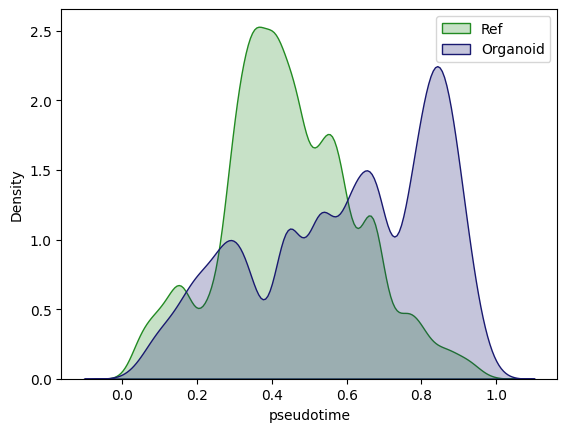

0.0 1.0
0.0 1.0


In [2]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_ref = anndata.read_h5ad(input_dir+'PanfetalATO_SPT_gplvm_ref_24012023.h5ad')
adata_query = anndata.read_h5ad(input_dir +'PanfetalATO_SPT_gplvm_ATO_24012023.h5ad') 
#adata_ref = anndata.read_h5ad('data/adata_ref_spt.h5ad')
#adata_query = anndata.read_h5ad('data/adata_ato_spt.h5ad') 
print(adata_ref.X.data)
print(adata_query.X.data)
print(adata_ref.shape)
print(adata_query.shape)

common_genes = np.intersect1d(adata_ref.var_names, adata_query.var_names)
len(common_genes )
def get_human_TF_list(): 
    # get a human TF list 
    TF_list = pd.read_csv('huamn_TF_list.csv',skiprows=1)
    np.unique(TF_list['Unnamed: 3'], return_counts=True) # There are only 1639 true TFs out of 2765 TFs in this list 
    TF_list = TF_list[TF_list['Unnamed: 3']=='Yes']
    TF_list['Name']
    return TF_list
human_TFs = get_human_TF_list()
human_TFs = np.intersect1d(common_genes , np.asarray(human_TFs['Name']) )
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Ref', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Organoid', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

print(min(adata_ref.obs['time']), max(adata_ref.obs['time'])) 
print(min(adata_query.obs['time']), max(adata_query.obs['time']))


In [9]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

14

In [10]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

15

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


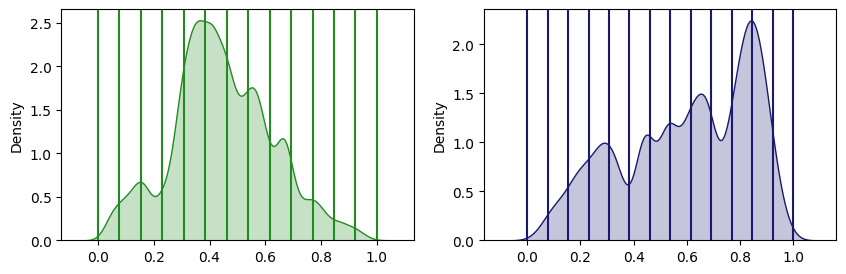

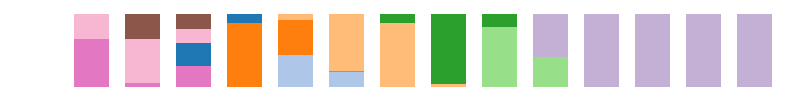

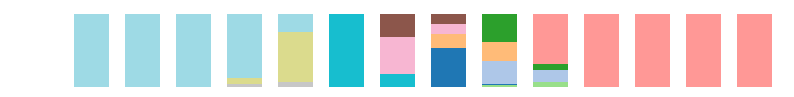

In [11]:
joint_cmap = {'IPSC': '#c7c7c7',
'PRIMITIVE_STREAK': '#9edae5',
'MESODERMAL_PROGENITOR': '#dbdb8d',
'ENDOTHELIUM': '#17becf',
'HSC_MPP': '#f7b6d2',
'HSC_MPP/LMPP_MLP/DC2': '#8c564b',
'LMPP_MLP': '#8c564b',
'CYCLING_MPP': '#e377c2',
'DN(EARLY)_T': '#1f77b4',
'DN(early)_T': '#1f77b4',
'DN_T': '#aec7e8',
'DN(P)_T': '#aec7e8',
'DN(Q)_T': '#ff7f0e',
'DP(P)_T': '#ffbb78',
'DP(Q)_T': '#2ca02c',
'ABT(ENTRY)': '#98df8a',
'SP_T': '#ff9896',
'TYPE_1_INNATE_T': '#c5b0d5'}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
#vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ref_timebins.pdf')
#vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ato_timebins.pdf')

In [5]:
    gene_list = human_TFs#['POU5F1','NANOG','SOX2','HHEX']
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 

WINDOW_SIZE= 0.1


  0%|          | 0/1371 [00:00<?, ?it/s]

In [12]:
with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_TF.pkl', 'rb') as f:
    aligner = pickle.load(f)

In [7]:
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_TF.pkl', 'wb')) 

In [7]:
    gene_list = ['JUNB','FOSB','KLF2','NR4A2','KLF2']
    aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.WINDOW_SIZE=0.1
    aligner.state_params = [0.99,0.1,0.7]
    aligner.optimal_binning = True
    aligner.opt_binning_S = vs.optimal_bining_S
    aligner.opt_binning_T = vs.optimal_bining_T
    aligner.align_all_pairs() 

WINDOW_SIZE= 0.1


  0%|          | 0/5 [00:00<?, ?it/s]

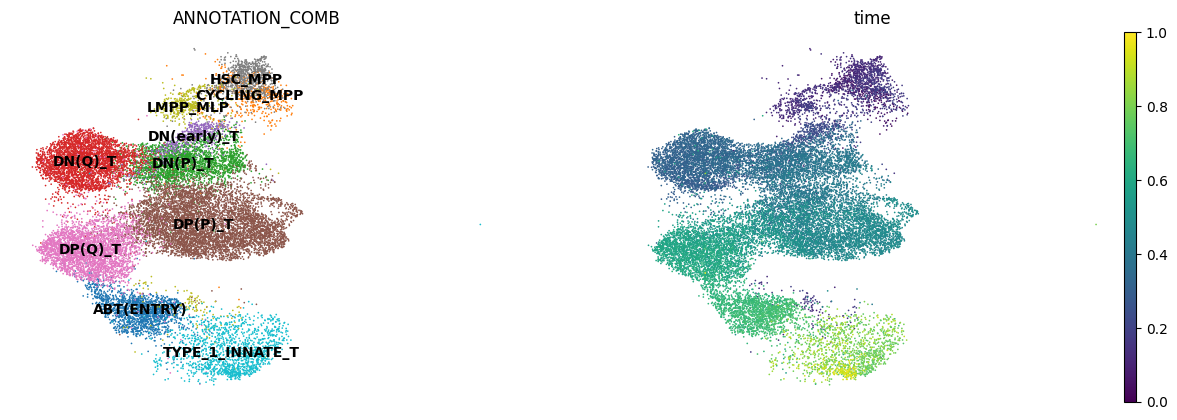

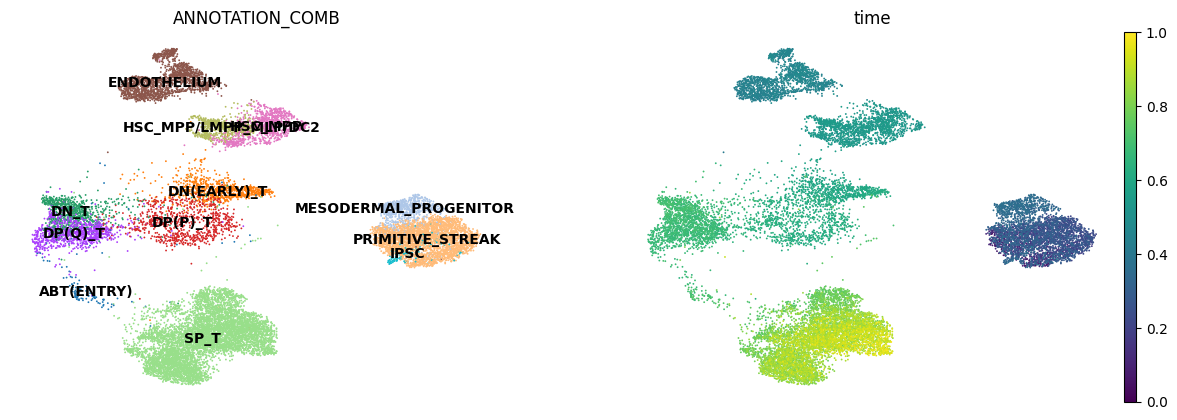

In [7]:
sc.pl.umap(adata_ref, color = ['ANNOTATION_COMB','time'], legend_loc='on data', frameon=False)
sc.pl.umap(adata_query, color = ['ANNOTATION_COMB','time'], legend_loc='on data', frameon=False)

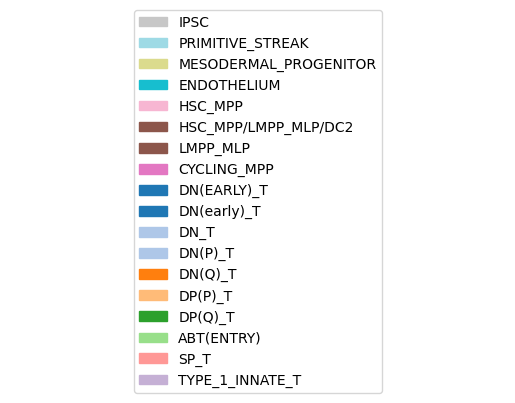

In [5]:
joint_cmap = {'IPSC': '#c7c7c7',
'PRIMITIVE_STREAK': '#9edae5',
'MESODERMAL_PROGENITOR': '#dbdb8d',
'ENDOTHELIUM': '#17becf',
'HSC_MPP': '#f7b6d2',
'HSC_MPP/LMPP_MLP/DC2': '#8c564b',
'LMPP_MLP': '#8c564b',
'CYCLING_MPP': '#e377c2',
'DN(EARLY)_T': '#1f77b4',
'DN(early)_T': '#1f77b4',
'DN_T': '#aec7e8',
'DN(P)_T': '#aec7e8',
'DN(Q)_T': '#ff7f0e',
'DP(P)_T': '#ffbb78',
'DP(Q)_T': '#2ca02c',
'ABT(ENTRY)': '#98df8a',
'SP_T': '#ff9896',
'TYPE_1_INNATE_T': '#c5b0d5'}
VisualUtils.plot_any_legend(joint_cmap)
#plt.savefig('plots/refato_joint_legend.pdf')

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


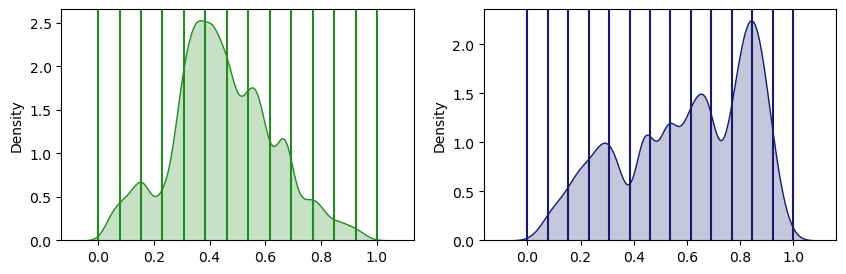

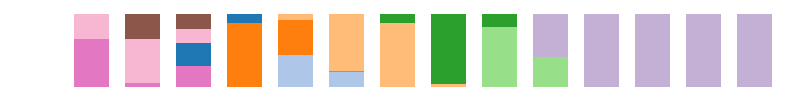

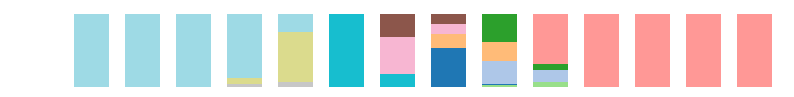

In [6]:
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=False)
#vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ref_timebins.pdf')
#vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ato_timebins.pdf')

Average Alignment:  IIIDDMMMMMMMMMMMD


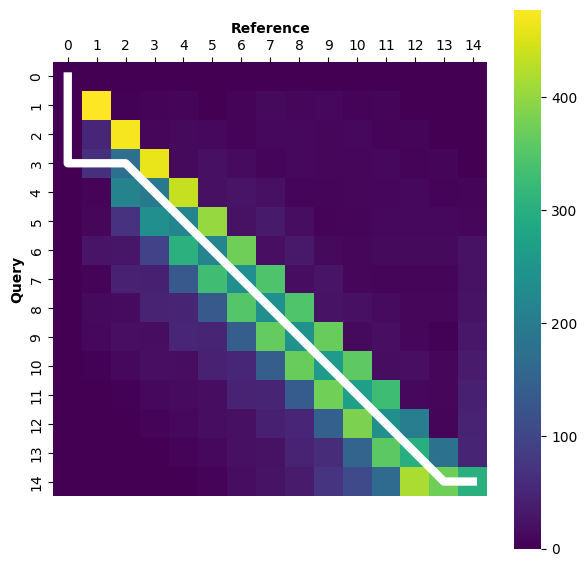

In [13]:
aligner.get_aggregate_alignment()
#plt.savefig('MS_FIGS/RefATO/average_TF_alignment.png')

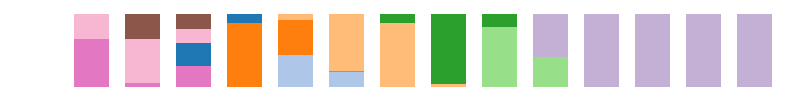

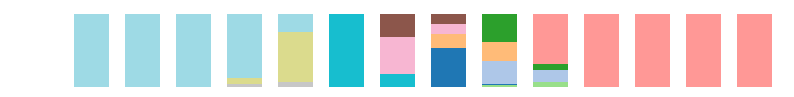

In [10]:
vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('MS_FIGS/RefATO/ref_timebins.pdf')
vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
plt.axis('off')
plt.savefig('MS_FIGS/RefATO/ato_timebins.pdf')

In [7]:
len(aligner.gene_list)

1371

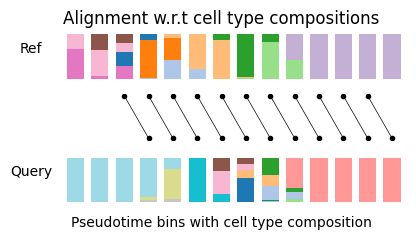

In [9]:
vs.visualize_gene_alignment("IIIDDMMMMMMMMMMMD", cmap=joint_cmap)
plt.savefig('MS_FIGS/RefATO/average_TF_alignment_illustration.png')

IIIIIDMMMMMMMMIDDDDD
Optimal alignment cost: 53.47106823738018 nits
Alignment similarity percentage: 40.0 %


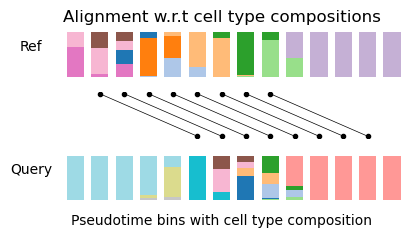

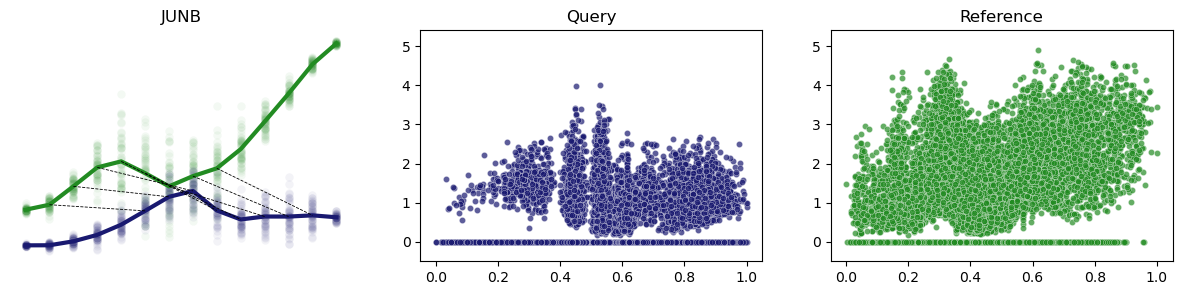

In [9]:
VisualUtils.show_gene_alignment('JUNB', aligner, vs, joint_cmap)
#plt.savefig('plots/Illustrations/gene_JUNB_refato.png')

# Identifying the most distant genes (differentially expressed)

mean matched percentage: 
65.67 %


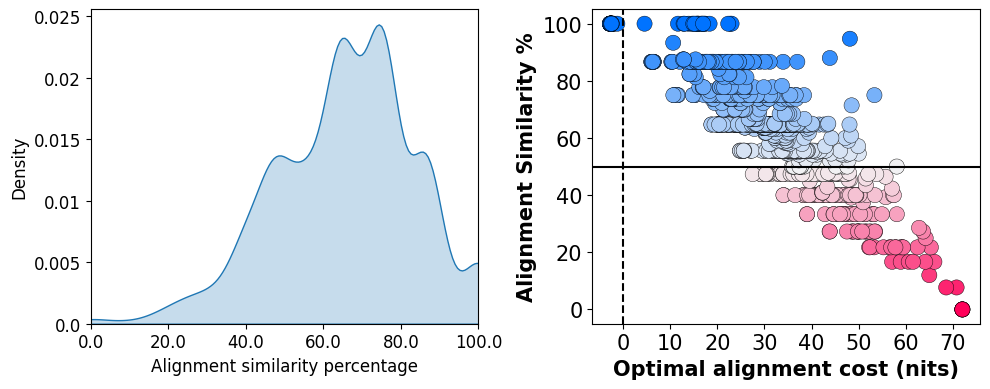

In [18]:
df = aligner.get_stat_df() #VisualUtils.plot_alignmentSim_vs_optCost(df, opt_cost_cut=50)
#plt.savefig('MS_FIGS/RefATO/al_dist.png')

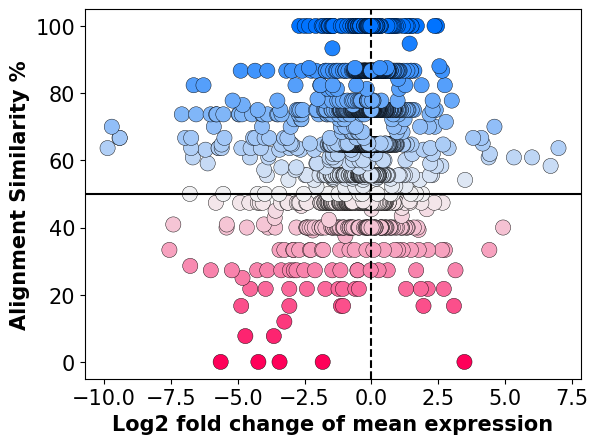

In [127]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

In [27]:
for g in pathway_df.loc[37]['Genes'].split(';'):
    print(g)
    #print(aligner.results_map[g].alignment_str)

ZNF320
ZNF540
ZNF221
ZNF324B
SP100
ZNF460
ZNF93
ZNF439
ZNF813
ZNF713
ZNF404
ZNF667
ZNF853
ZNF841
ZNF114
ZNF730
ZNF850
ZNF442


IIIDIDIMMMMMMMMIDDDD
Optimal alignment cost: 44.307 nits
Alignment similarity percentage: 40.0 %


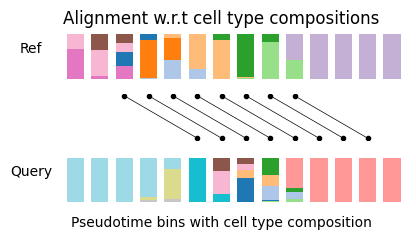

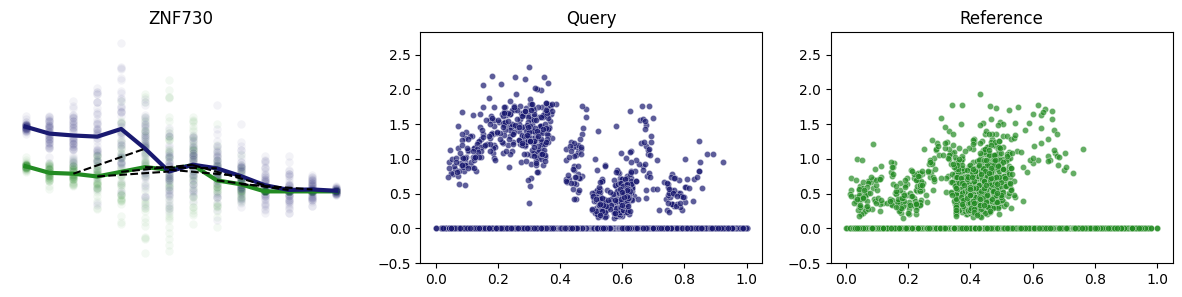

In [29]:
VisualUtils.show_gene_alignment('ZNF730', aligner, vs, joint_cmap)

In [31]:
len(topDEgenes )

150

In [14]:
# selecting reasonable thresholds by manual inspection to identify top/highly distant genes
# this call might sometime gives 'error sending list' from GSEAPy package function call -
#topDEgenes = df[np.logical_and(list(df['opt_alignment_cost'] >=50), list(df['alignment_similarity_percentage'] <=0.5))]['Gene']
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

Gene_set                                     Term Overlap  \
37       KEGG_2021_Human         Herpes simplex virus 1 infection  18/498   
0   MSigDB_Hallmark_2020            TNF-alpha Signaling via NF-kB  10/200   
38       KEGG_2021_Human                Th17 cell differentiation   6/107   
39       KEGG_2021_Human  Transcriptional misregulation in cancer   7/192   
40       KEGG_2021_Human  Human T-cell leukemia virus 1 infection   7/219   
41       KEGG_2021_Human                              Hepatitis B   6/162   
42       KEGG_2021_Human               Inflammatory bowel disease    4/65   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
37  3.839640e-08          0.000005            0                     0   
0   2.774494e-06          0.000103            0                     0   
38  1.560807e-04          0.009209            0                     0   
39  6.242605e-04          0.024554            0                     0   
40  1.345082e-03          0.028378            0                     0   
41  1.410465e-03          0.028378            0                     0   
42  1.442965e-03          0.028378            0                     0   

    Odds Ratio  Combined Score  \
37    5.502841       93.962671   
0     7.390977       94.567867   
38    8.147277       71.412004   
39    5.203364       38.395327   
40    4.534437       29.978526   
41    5.260150       34.526757   
42    8.887941       58.136514   

                                                Genes  \
37  ZNF320;ZNF540;ZNF221;ZNF324B;SP100;ZNF460;ZNF9...   
0   KLF10;NR4A1;JUN;CEBPD;MAFF;REL;MXD1;KLF4;JUNB;...   
38                  JUN;TBX21;RORC;NFATC2;HIF1A;RUNX1   
39            HOXA10;MEIS1;MEF2C;SPI1;REL;HMGA2;RUNX1   
40            JUN;SPI1;MSX2;CREB3L1;E2F2;NFATC2;CREB5   
41                JUN;CREB3L1;STAT4;E2F2;NFATC2;CREB5   
42                               JUN;TBX21;RORC;STAT4   

    -log10 Adjusted P-value  -log10 FDR q-val  
37                 5.343828          5.343828  
0                  3.988614          3.988614  
38                 2.035799          2.035799  
39                 1.609873          1.609873  
40                 1.547014          1.547014  
41                 1.547014          1.547014  
42                 1.547014          1.547014

In [33]:
#pathway_df.to_csv('results/SPT_overrep_results_top_k_DE_threshold_0.4sim_150genes.csv')

# Clustering genes using their alignments

Running cluster diagnostics to decide on a distance threshold with a good tradeoff between the number of clusters and the quality of structure

compute distance matrix
using levenshtein distance metric


 74%|███████▎  | 73/99 [00:23<00:08,  3.04it/s]


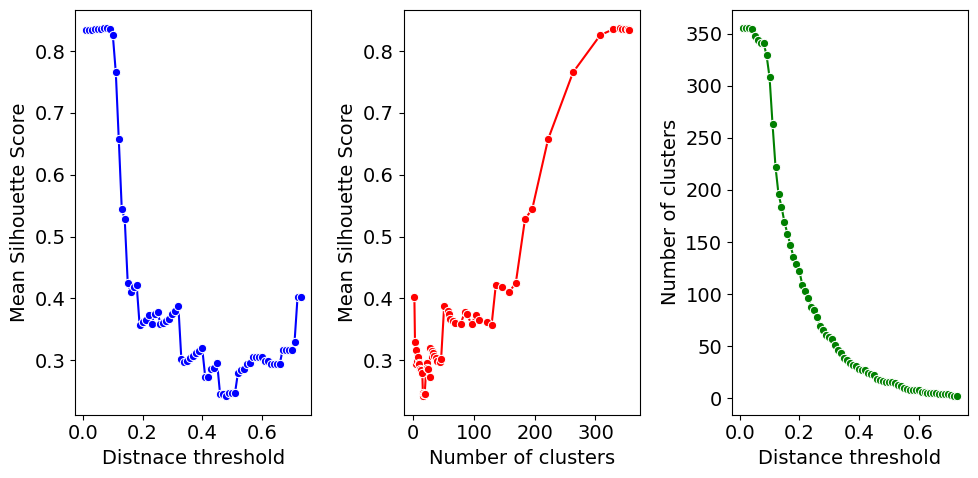

In [35]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 
plt.savefig('MS_FIGS/RefATO/Clustering_Diagnostics_plots_levenshtein.png')

In [74]:
df.sort_values('Number of clusters')[20:60]

Distance threshold  Mean Silhouette Score  Number of clusters
52                0.53               0.284327                13.0
51                0.52               0.279952                15.0
50                0.51               0.246774                16.0
49                0.50               0.246774                16.0
48                0.49               0.246774                16.0
47                0.48               0.241820                17.0
46                0.47               0.245170                18.0
45                0.46               0.245539                19.0
44                0.45               0.296134                22.0
43                0.44               0.287130                23.0
42                0.43               0.286363                24.0
41                0.42               0.273833                27.0
40                0.41               0.273833                27.0
39                0.40               0.319353                28.0
38                0.39               0.314637                31.0
37                0.38               0.312519                32.0
36                0.37               0.306913                34.0
35                0.36               0.304416                37.0
34                0.35               0.298179                39.0
33                0.34               0.296891                44.0
32                0.33               0.302251                46.0
31                0.32               0.387553                51.0
30                0.31               0.379982                57.0
29                0.30               0.374422                59.0
28                0.29               0.366107                61.0
27                0.28               0.363889                66.0
26                0.27               0.361021                69.0
25                0.26               0.359099                78.0
24                0.25               0.377578                85.0
23                0.24               0.375511                88.0
22                0.23               0.358227                96.0
21                0.22               0.373483               103.0
20                0.21               0.365287               109.0
19                0.20               0.361946               122.0
18                0.19               0.356734               129.0
17                0.18               0.421858               136.0
16                0.17               0.419306               147.0
15                0.16               0.410048               158.0
14                0.15               0.425734               169.0
13                0.14               0.528184               184.0

By examining the above, we see the second highest locally optiml score as giving a good tradeoff. Therefore we select 0.69 as the threshold. You can filter the df to identify the locally optimal points to test

In [34]:
#df[df['Mean Silhouette Score'] >0.5].sort_values('Distance threshold', ascending=False)

# Obtain clustering for the selected distance threshold
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.45) # 0.45 (low res) 0.18 (high res)
#ClusterUtils.visualise_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clusters_low_res.png')
#VisualUtils.plot_distmap_with_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clustermap_low_res.png', bbox_inches='tight')

#VisualUtils.plot_distmap_with_clusters(aligner,genes2highlight=['POU5F1','NANOG','SOX2','HHEX','FOSB','JUNB','NR4A2','KLF2'])

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.45
silhouette_score:  0.29613417685203286


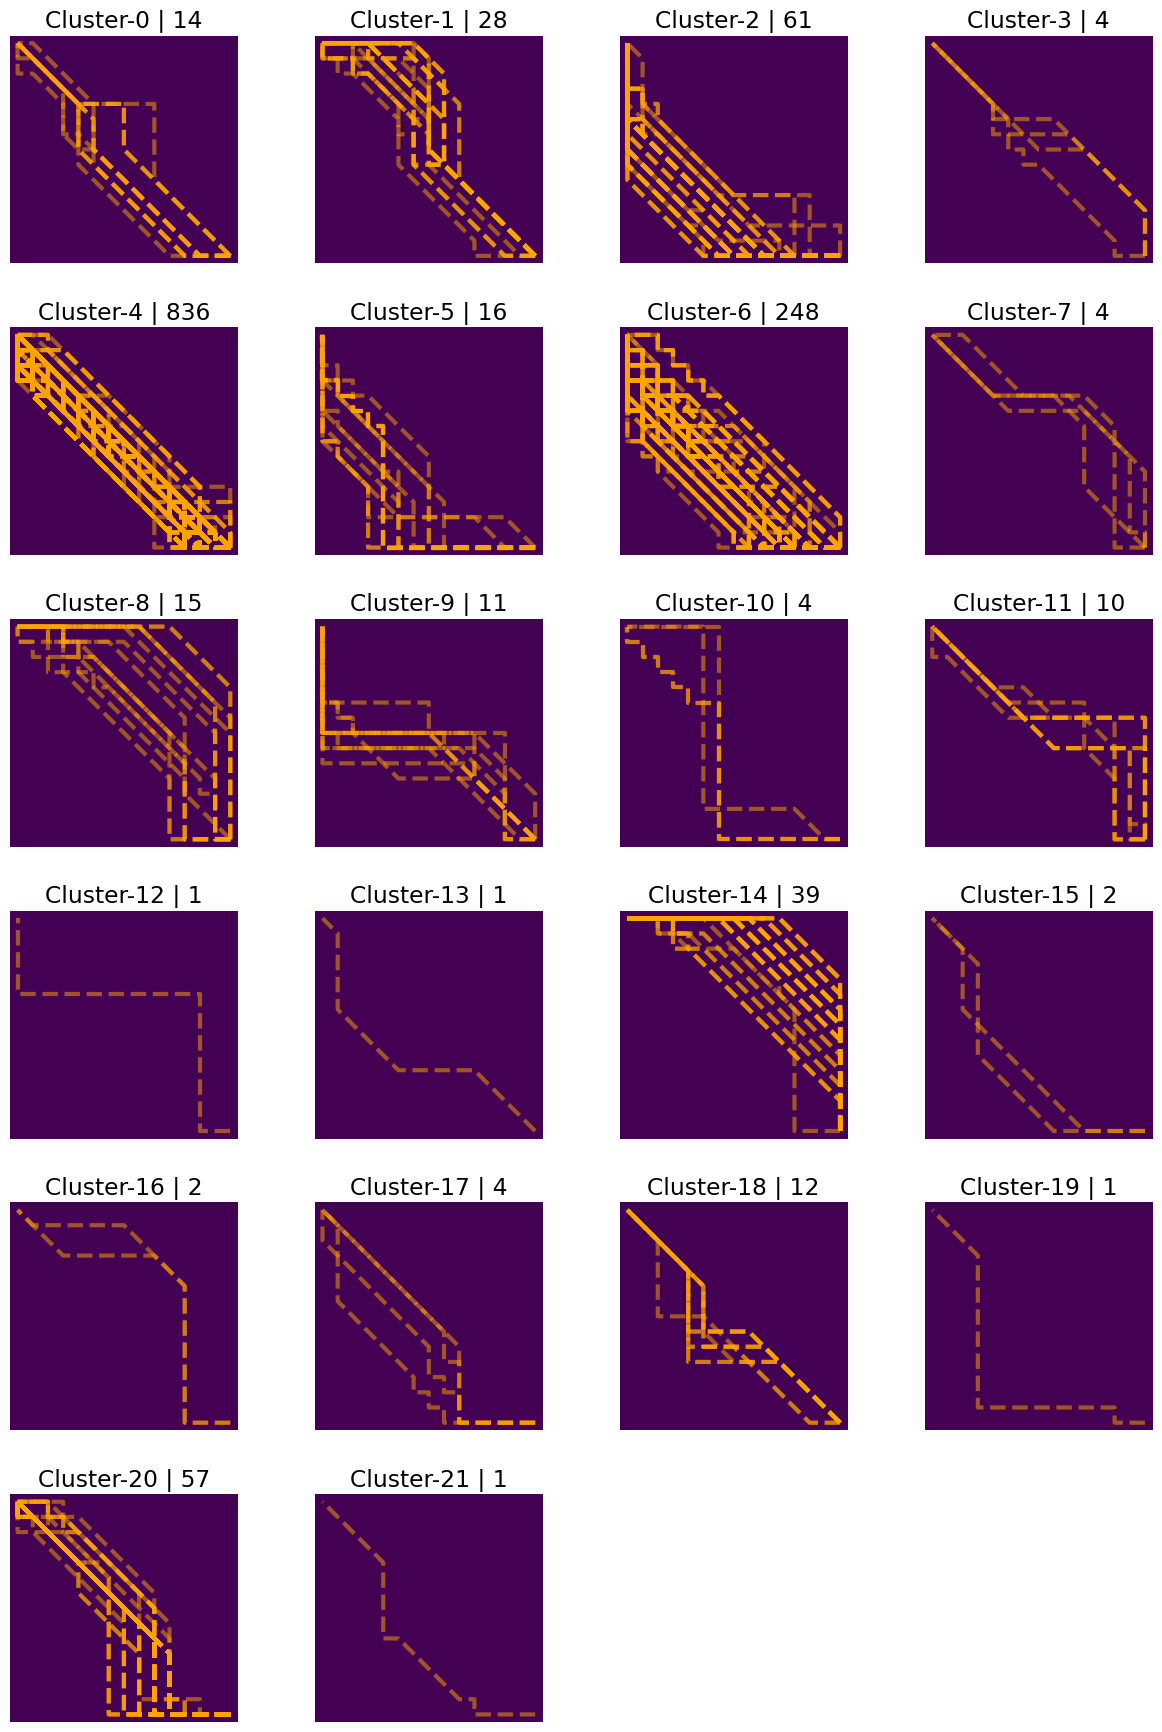

In [154]:
ClusterUtils.visualise_clusters(aligner, n_cols=4)
plt.savefig('MS_FIGS/RefATO/clusters_low_res.png')

In [ ]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.patches as mpatches
def plot_distmap_with_clusters(aligner, cmap=None, vmin = 0.0, vmax = 1.0, genes2highlight=None):
    
    godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation, 
        '#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161',
       '#fbafe4', '#949494', '#ece133', '#56b4e9', # <--added colorblind palette to this
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]
    
    # ordering genes by packing them into their clusters
    cluster_ordered_genes = []
    cluster_ids = []
    
    cluster_lens = []
    for i in aligner.gene_clusters.keys():
        cluster_lens.append(len(aligner.gene_clusters[i]))
    c_keys = np.asarray(list(aligner.gene_clusters.keys()) ) [np.argsort(cluster_lens)[::-1]] # ordered according to cluster size
    for i in c_keys:
        cluster_ordered_genes  += aligner.gene_clusters[i]
        cluster_ids += list(np.repeat(i,len(aligner.gene_clusters[i]))) 
    temp = pd.DataFrame([cluster_ordered_genes, cluster_ids]).transpose() 
    temp.columns = ['Gene','cluster_id']

    n_clusters = len(aligner.gene_clusters.keys())
    if(n_clusters<=20):
        color_list = list(sb.color_palette('colorblind'))[0:n_clusters] 
    else:
        if(cmap is not None):
            orig_cmap = plt.cm.get_cmap(cmap)
            custom_cmap = orig_cmap(np.linspace(vmin, vmax, n_clusters))
            color_list = [mcolors.rgb2hex(custom_cmap[i]) for i in range(n_clusters)]
        else:
            color_list = godsnot_64[0:n_clusters]
        #np.random.seed(3); np.random.shuffle(color_list)

    x = dict(zip(temp['cluster_id'].unique(), color_list )) 
    rcolors = pd.Series(temp['cluster_id']).map(x)
    rcolors.name = ''
    x = aligner.DistMat[cluster_ordered_genes].loc[cluster_ordered_genes]   
    p = sb.clustermap(x.reset_index(drop=True), cmap='viridis', 
                      square=True, row_cluster=False, col_cluster=False, row_colors=rcolors, figsize=(10,10), xticklabels=False,
                      cbar_pos=(1.05, 0.54, 0.02, 0.25))
    if(genes2highlight is None):
        gene_labels = []
        for tick_label in p.ax_heatmap.axes.get_yticklabels():
            tick_text = tick_label.get_text()
            gene = temp.Gene.loc[int(tick_text)]
            tick_label.set_color(rcolors[int(tick_text)])
            gene_labels.append(gene)
        p.ax_heatmap.axes.set_yticklabels(gene_labels, rotation = 0) 
    else:
        tick_indices = []
        for g in genes2highlight:
            tick_indices.append(temp.index[temp['Gene']==g][0]) 
        p.ax_heatmap.axes.set_yticks(tick_indices) 
        p.ax_heatmap.axes.set_yticklabels(genes2highlight, rotation = 0) 
        
        k=0
        for tick_label in p.ax_heatmap.axes.get_yticklabels():
            tick_label.set_color(rcolors[tick_indices[k]])
            k+=1

    # plotting the legend of clusters
    legend_labels = ['Cluster-'+str(k) for k in c_keys] 
    legend_patches = [mpatches.Patch(color=color_list[i], label=legend_labels[i]) for i in range(len(color_list))]
    ax = p.ax_row_dendrogram
    ax.legend(handles=legend_patches, loc='center')
    ax.axis('off'); ax.set_xticks([]); ax.set_yticks([]); 

plot_distmap_with_clusters(aligner)
plt.savefig('MS_FIGS/RefATO/clustermap_low_res.png', bbox_inches='tight')


In [148]:
for g in ['SOX2', 'MEIS1', 'DLX5', 'HAND1', 'SMAD9' ,
'NANOG', 'OTX1', 'ISL1', 'POU5F1', 'TBX3',
'TEAD4', 'SNAI2', 'TEAD1', 'TEAD2', 'GLI2']:
    if(g in aligner.gene_clusters[2]):
        print(g)

#DLX5;HAND1;NANOG;ISL1;POU5F1;TBX3

DLX5
HAND1
NANOG
ISL1
POU5F1
TBX3
TEAD1
GLI2


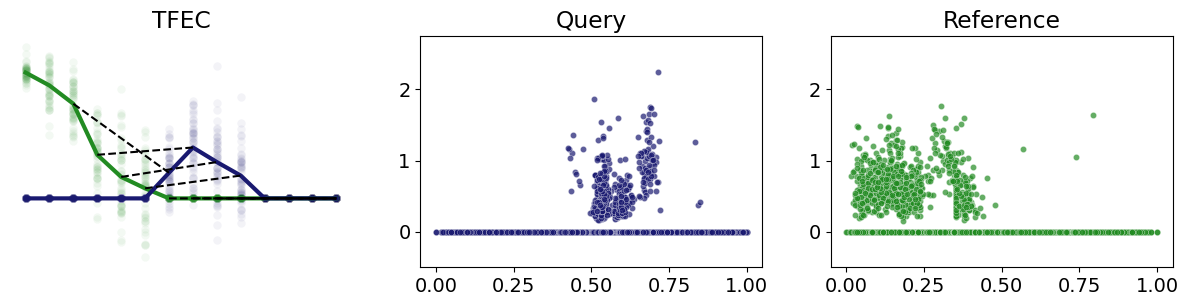

In [151]:
VisualUtils.plotTimeSeries('TFEC', aligner)

In [132]:
#ClusterUtils.print_cluster_average_alignments(aligner)

In [133]:
temp = []
for a in aligner.results:
    temp.append(a.alignment_str)
len(np.unique(temp))

355

In [134]:
#ClusterUtils.print_cluster_average_alignments(aligner)

In [174]:
aligner.results_map['BATF2'].cluster_id

4

In [109]:
aligner.gene_clusters[0] # hicluster_ides.. middle mismatched cluster

['CSRNP3',
 'DMRTA1',
 'FOXF1',
 'GATA4',
 'GLIS3',
 'MSC',
 'PBX1',
 'POU6F1',
 'SCX',
 'SNAI2',
 'SOX18',
 'SP8',
 'TBX1',
 'ZNF157']

In [135]:
# hippo signalling TFs
#for g in ['TEAD1','TEAD2','TEAD3','TEAD4']:
#    print(aligner.results_map[g].cluster_id)
#    print(aligner.results_map[g].alignment_str)

In [36]:
pluripotent_df = PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[2])
pluripotent_df 

Gene_set                                               Term  \
14  KEGG_2021_Human  Signaling pathways regulating pluripotency of ...   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
14   6/143  0.000005          0.000048            0                     0   

    Odds Ratio  Combined Score                              Genes  \
14   15.768016      193.006093  DLX5;HAND1;NANOG;ISL1;POU5F1;TBX3   

    -log10 Adjusted P-value  -log10 FDR q-val  
14                 4.315918          4.315918

In [38]:
pluripotent_df.to_csv('results/SPT_overrep_results_pluripotent.csv')

In [145]:
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[14])

Gene_set                                     Term Overlap   P-value  \
7  KEGG_2021_Human         Herpes simplex virus 1 infection   7/498  0.000044   
8  KEGG_2021_Human  Transcriptional misregulation in cancer   4/192  0.000521   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
7          0.001096            0                     0    8.674262   
8          0.006507            0                     0   12.020061   

   Combined Score                                           Genes  \
7       87.042701  ZNF177;ZNF471;ZNF492;ZNF99;ZNF257;ZNF135;ZFP28   
8       90.878769                             CEBPA;SPI1;PAX8;ERG   

   -log10 Adjusted P-value  -log10 FDR q-val  
7                 2.960029          2.960029  
8                 2.186613          2.186613

In [224]:
# Obtain clustering for the selected distance threshold
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.45) #0.18 
#ClusterUtils.visualise_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clusters_low_res.png')#VisualUtils.plot_distmap_with_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clustermap_low_res.png', bbox_inches='tight')
#plot_distmap_with_clusters(aligner)
#plt.savefig('MS_FIGS/RefATO/clustermap_high_res.png', bbox_inches='tight')
#VisualUtils.plot_distmap_with_clusters(aligner,genes2highlight=['POU5F1','NANOG','SOX2','HHEX','FOSB','JUNB','NR4A2','KLF2'])

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.45
silhouette_score:  0.29613417685203286


In [265]:
aligner.results_map['LEF1'].cluster_id

13

In [225]:
ClusterUtils.print_cluster_average_alignments(aligner)
#for i in range(0,21):
#    print('NANOG' in aligner.gene_clusters[i]) 

cluster:  0 MMMMIIIDMMMMWMMMW 14
cluster:  1 IDDDDMMMMIIIMMMMMM 28
cluster:  2 IIIDIDIIMMMMMMMMWWWW 61
cluster:  3 MMMMVMMIDDDDMVMMMV 4
cluster:  4 IIDMMMMMMMMMMMMD 836
cluster:  5 IIIDIDIDIDIIIIIIIIDDDDDDDDDD 16
cluster:  6 IIIDIDIDMMMMMMMMMDD 248
cluster:  7 MMMMDDDDMWMMMIDIIIII 4
cluster:  8 IIDDDDDDMMMMMWIIIDIIIID 15
cluster:  9 IIIDIDIDIMMMWWIWWMMMM 11
cluster:  10 IIIDIDIDIDIIDMVVVVVDDDDDDDD 4
cluster:  11 MMMWMMMWMWIWWWIDIIIII 10
cluster:  12 IIIDIDDMWWWWWWWIMVVVVVVMD 1
cluster:  13 IMVMVVMMMMWWWWMMMM 1
cluster:  14 IIDDDDDDDMMMMMMMVVVVV 39
cluster:  15 IMMVDVVDMWMMMMMMMW 2
cluster:  16 MMMMWMDDDMVMVMVVVMD 2
cluster:  17 IIMMMMMMIIMDIDIIDDDDD 4
cluster:  18 MMMMVVVVDVDDDDMMMMM 12
cluster:  19 IIDMMVVVVVVMMWMWWWWWMD 1
cluster:  20 MMMIMMMMMMVVDVVDDDD 57
cluster:  21 MMMMVVVVVMMMMMDDDDD 1


In [270]:
for g in aligner.gene_clusters[21]:
    print(g, aligner.results_map[g].alignment_str)

FOXP3 MMMMVVVVVDMMMMDIDDDD


In [252]:
for g in aligner.gene_clusters[5]:
    print(g, aligner.results_map[g].alignment_str)

GATA6 IIIDIDIDIDIIIIIIIIDDDDDDDDDD
GLIS1 IIIIIMMMMMVVVVDDDDDDDDD
HEY1 IIDIDIDMMMMIIIIIIDDDDDDD
HOXB6 IIIIIIIDIMMIIIIDDDDDDDDDDD
JUN IIIMMMMIIDIIIIIDDDDDDDDD
MXD1 IIIIIIMMMMMIIIDDDDDDDDD
NACC2 IIIIIIIDIMMIIIIDDDDDDDDDDD
NKRF IIIIIIIMMMMMDDDDDDDMM
NME2 IIIDIDIDIDIIIIIIIIDDDDDDDDDD
PAX9 IIIDIDIDIDIIIIIIIIDDDDDDDDDD
POU6F2 IIIDIDIDIDIIIIIIIIDDDDDDDDDD
PRDM6 IIIDIDIDIDIIIIIIIIDDDDDDDDDD
RAG1 IIIIIDIMMMMMIIIDDDDDDDD
SALL4 IIIIIIIDIMMIIDDDDDDDMMDD
TIGD5 IIIDIMMMMMMMVVVDDDDDD
ZNF469 IIIDIMMMMMMVVVVDDDDDDD


In [237]:
'TCF1' in adata_query.var_names

GATA6,SALL4,HOXB6,NACC2,PRDM6

False

In [276]:
a = aligner.align_single_pair('CCR7')

In [277]:
aligner.results_map['CCR7'] = a

In [275]:
ali

True

MVVVVVMMMMMIDIDIDDDDDD
Optimal alignment cost: 46.779 nits
Alignment similarity percentage: 50.0 %


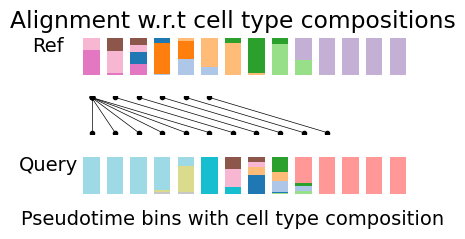

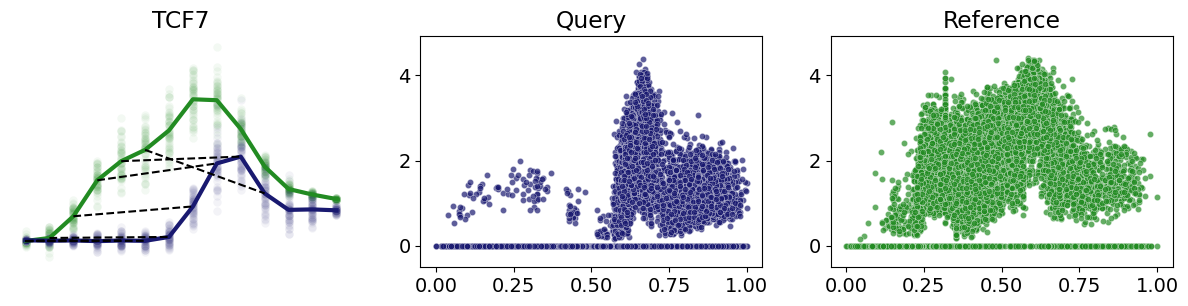

In [279]:
VisualUtils.show_gene_alignment('TCF7', aligner, vs, joint_cmap)

MMMMVVVVVDMMMMDIDDDD
Optimal alignment cost: 28.324 nits
Alignment similarity percentage: 65.0 %


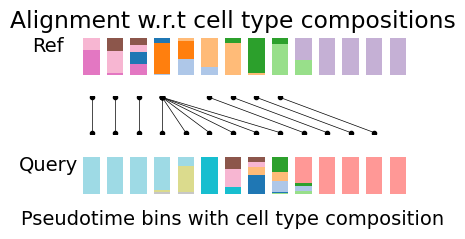

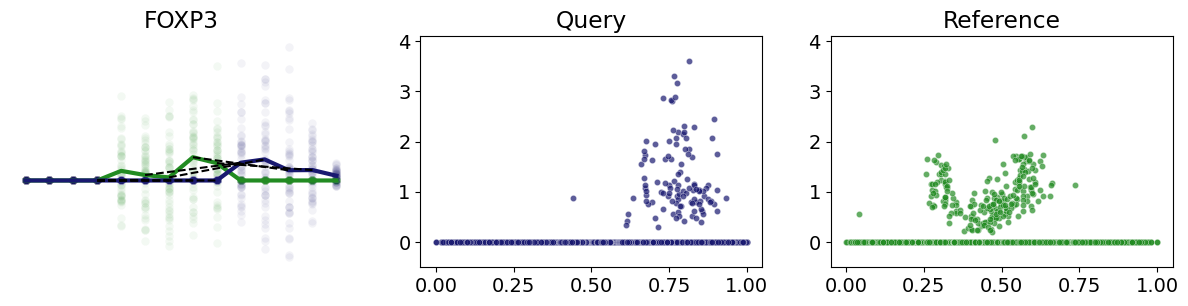

In [271]:
VisualUtils.show_gene_alignment('FOXP3', aligner, vs, joint_cmap)

MVVVVVMMMMWWWWDMMMM
Optimal alignment cost: 48.164 nits
Alignment similarity percentage: 94.74 %


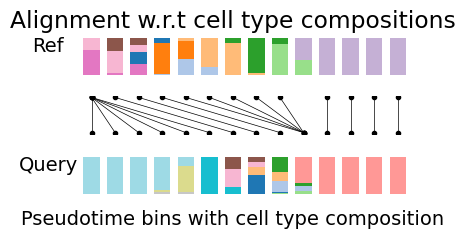

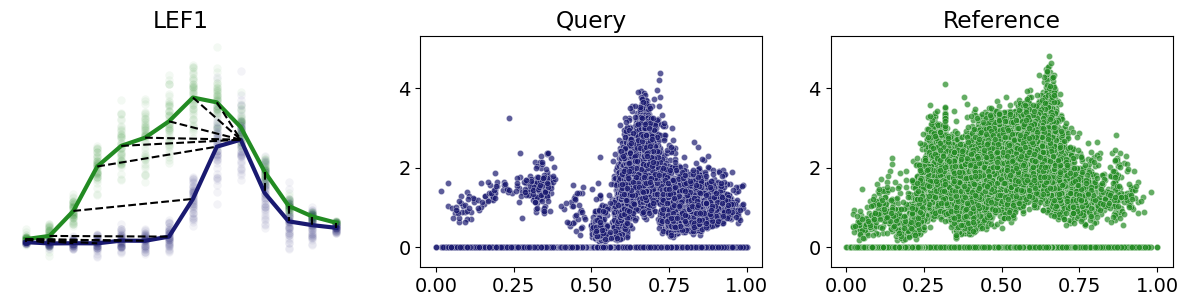

In [233]:
VisualUtils.show_gene_alignment('LEF1', aligner, vs, joint_cmap)

In [246]:
cluster_id = 9
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])

Gene_set                                     Term Overlap   P-value  \
7  KEGG_2021_Human                   Acute myeloid leukemia    2/67  0.000596   
8  KEGG_2021_Human  Transcriptional misregulation in cancer   2/192  0.004763   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
7          0.005963            0                     0   68.116239   
8          0.023816            0                     0   23.156725   

   Combined Score         Genes  -log10 Adjusted P-value  -log10 FDR q-val  
7      505.747827  CEBPE;ZBTB16                 2.224539          2.224539  
8      123.815530  CEBPE;ZBTB16                 1.623137          1.623137

In [211]:
#PathwayAnalyserV2.run_overrepresentation_analysis(list(aligner.gene_list)) 

In [205]:
#for g in aligner.gene_clusters[1]:
#    print(g, aligner.results_map[g].alignment_str)
#    VisualUtils.plotTimeSeries(g,aligner)

In [261]:
cluster_id = 2
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])
#for i in range(0,21):
#    print('NANOG' in aligner.gene_clusters[i]) 

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [182]:
aligner.results_map['POU5F1'].cluster_id

2

In [180]:
cluster_id = 14
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])

Gene_set                                     Term Overlap   P-value  \
7  KEGG_2021_Human         Herpes simplex virus 1 infection   7/498  0.000044   
8  KEGG_2021_Human  Transcriptional misregulation in cancer   4/192  0.000521   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
7          0.001096            0                     0    8.674262   
8          0.006507            0                     0   12.020061   

   Combined Score                                           Genes  \
7       87.042701  ZNF177;ZNF471;ZNF492;ZNF99;ZNF257;ZNF135;ZFP28   
8       90.878769                             CEBPA;SPI1;PAX8;ERG   

   -log10 Adjusted P-value  -log10 FDR q-val  
7                 2.960029          2.960029  
8                 2.186613          2.186613

In [183]:
cluster_id = 2
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])

Gene_set                                               Term  \
14  KEGG_2021_Human  Signaling pathways regulating pluripotency of ...   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
14   6/143  0.000005          0.000048            0                     0   

    Odds Ratio  Combined Score                              Genes  \
14   15.768016      193.006093  DLX5;HAND1;NANOG;ISL1;POU5F1;TBX3   

    -log10 Adjusted P-value  -log10 FDR q-val  
14                 4.315918          4.315918

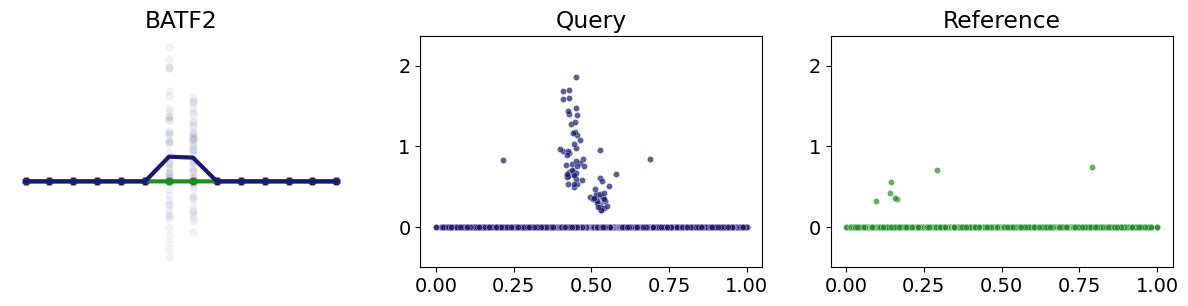

In [206]:
VisualUtils.plotTimeSeries('BATF2', aligner)

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.69
silhouette_score:  0.600899978958553


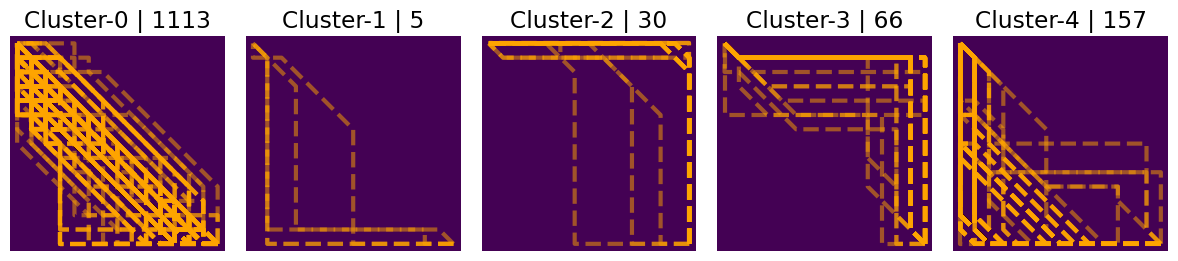

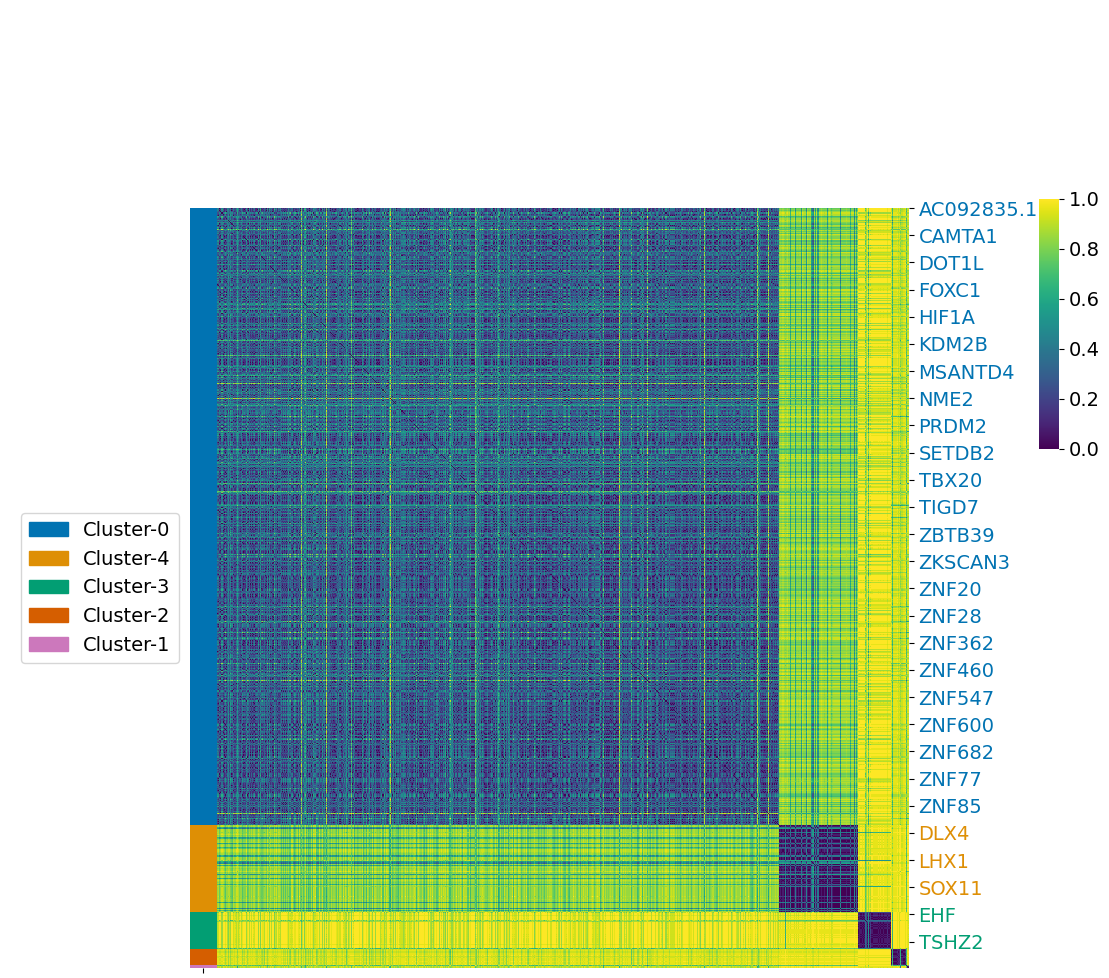

In [124]:
# Obtain clustering for the selected distance threshold
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.69) 
ClusterUtils.visualise_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clusters_low_res.png')
VisualUtils.plot_distmap_with_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clustermap_low_res.png', bbox_inches='tight')

#VisualUtils.plot_distmap_with_clusters(aligner,genes2highlight=['POU5F1','NANOG','SOX2','HHEX','FOSB','JUNB','NR4A2','KLF2'])

In [116]:
aligner.results_map['HHEX'].alignment_str

'IIIDIDIDMMMMMMMMMDD'

In [129]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIDMMMMMMMMMMMMD 1113
cluster:  1 IIDVVVDVVVVVVMMDDDDDDDDMD 5
cluster:  2 IIIDDDDDDDDDDDDDMVVVVVVVVVV 30
cluster:  3 MWWWWWWWWWWWWWIIIIIIIIIIIII 66
cluster:  4 IIIIIDIIIIMMMMMWWWWWWWW 157


In [133]:
'SOX2' in aligner.gene_clusters[4]



True

In [30]:
#aligner.show_cluster_alignment_strings(2)

In [31]:
aligner.gene_clusters[1]

['BATF3', 'GRHL1', 'MEOX1', 'POU2AF1', 'POU3F1']

### Checking cluster-specific overepresentation

In [33]:
cluster_id = 4
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[cluster_id])

Gene_set                                               Term  \
23  KEGG_2021_Human  Signaling pathways regulating pluripotency of ...   
24  KEGG_2021_Human            Transcriptional misregulation in cancer   
25  KEGG_2021_Human                            Hippo signaling pathway   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
23  10/143  1.946485e-07          0.000008            0                     0   
24   9/192  2.140195e-05          0.000449            0                     0   
25   6/163  1.835065e-03          0.025691            0                     0   

    Odds Ratio  Combined Score  \
23   10.081326      155.777358   
24    6.533008       70.243092   
25    4.982326       31.392018   

                                                Genes  \
23  SOX2;MEIS1;DLX5;HAND1;SMAD9;NANOG;OTX1;ISL1;PO...   
24  ARNT2;CEBPA;LYL1;MEIS1;SPI1;SIX4;ETV1;ETV4;HOXA11   
25                  SOX2;TEAD4;SNAI2;TEAD1;TEAD2;GLI2   

    -log10 Adjusted P-value  -log10 FDR q-val  
23                 5.087500          5.087500  
24                 3.347327          3.347327  
25                 1.590220          1.590220

In [134]:
#aligner.show_cluster_alignment_strings(4)
#for g in ['SOX2','TEAD4','SNAI2','TEAD1','TEAD2','GLI2']:
#    print(aligner.results_map[g].alignment_str)

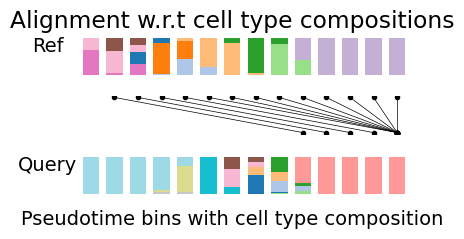

In [34]:
vs.visualize_gene_alignment('IIIIIDIIIIMMMMMWWWWWWWW', cmap=joint_cmap) 

### Checking the distance threshold which gives the next highest locally optimal mean silhouette socre

In [39]:
df[df['Mean Silhouette Score'] < 0.45].sort_values('Distance threshold', ascending=False)

Distance threshold  Mean Silhouette Score  Number of clusters
52                0.53               0.431036                12.0
51                0.52               0.431036                12.0
50                0.51               0.431036                12.0
49                0.50               0.431367                13.0
48                0.49               0.431367                13.0
47                0.48               0.401132                16.0
46                0.47               0.395612                18.0
45                0.46               0.395612                18.0
44                0.45               0.395612                18.0
43                0.44               0.395612                18.0
42                0.43               0.391334                20.0
41                0.42               0.392261                21.0
40                0.41               0.392261                21.0
39                0.40               0.376876                23.0
38                0.39               0.376876                23.0
37                0.38               0.376876                23.0
36                0.37               0.431507                24.0
35                0.36               0.424014                27.0
34                0.35               0.420569                29.0
33                0.34               0.412021                32.0
32                0.33               0.403077                34.0
31                0.32               0.390440                39.0
30                0.31               0.406115                41.0
29                0.30               0.405028                42.0
28                0.29               0.396754                44.0
27                0.28               0.391898                45.0
26                0.27               0.388729                47.0
25                0.26               0.395044                51.0
24                0.25               0.448120                56.0
23                0.24               0.448120                56.0
22                0.23               0.446156                59.0
19                0.20               0.446539                68.0

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.37
silhouette_score:  0.4315067530388812


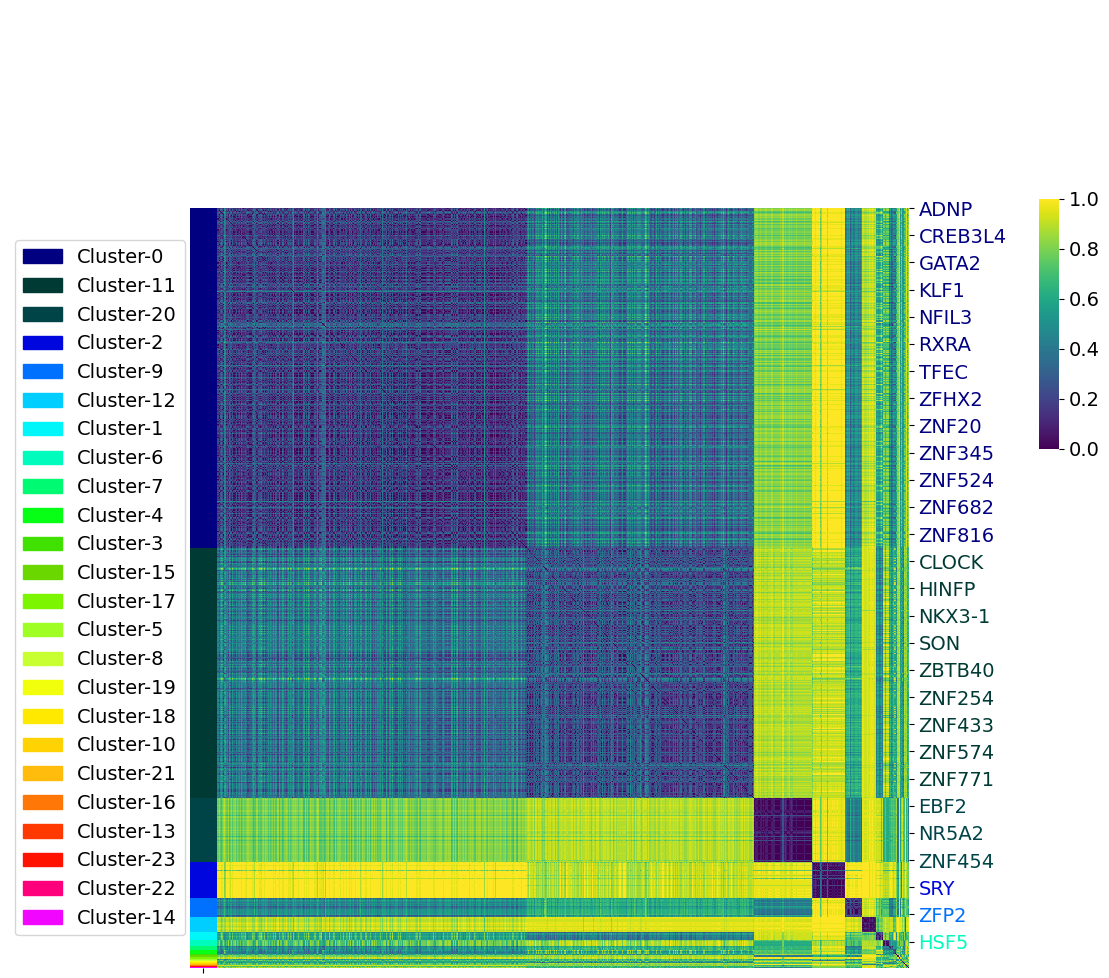

In [117]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.37) 
VisualUtils.plot_distmap_with_clusters(aligner,cmap='gist_ncar',vmin = 0, vmax = 0.8)
#plt.savefig('plots/ExtendedFigsATOREF/clustermap_high_res.png', bbox_inches='tight')

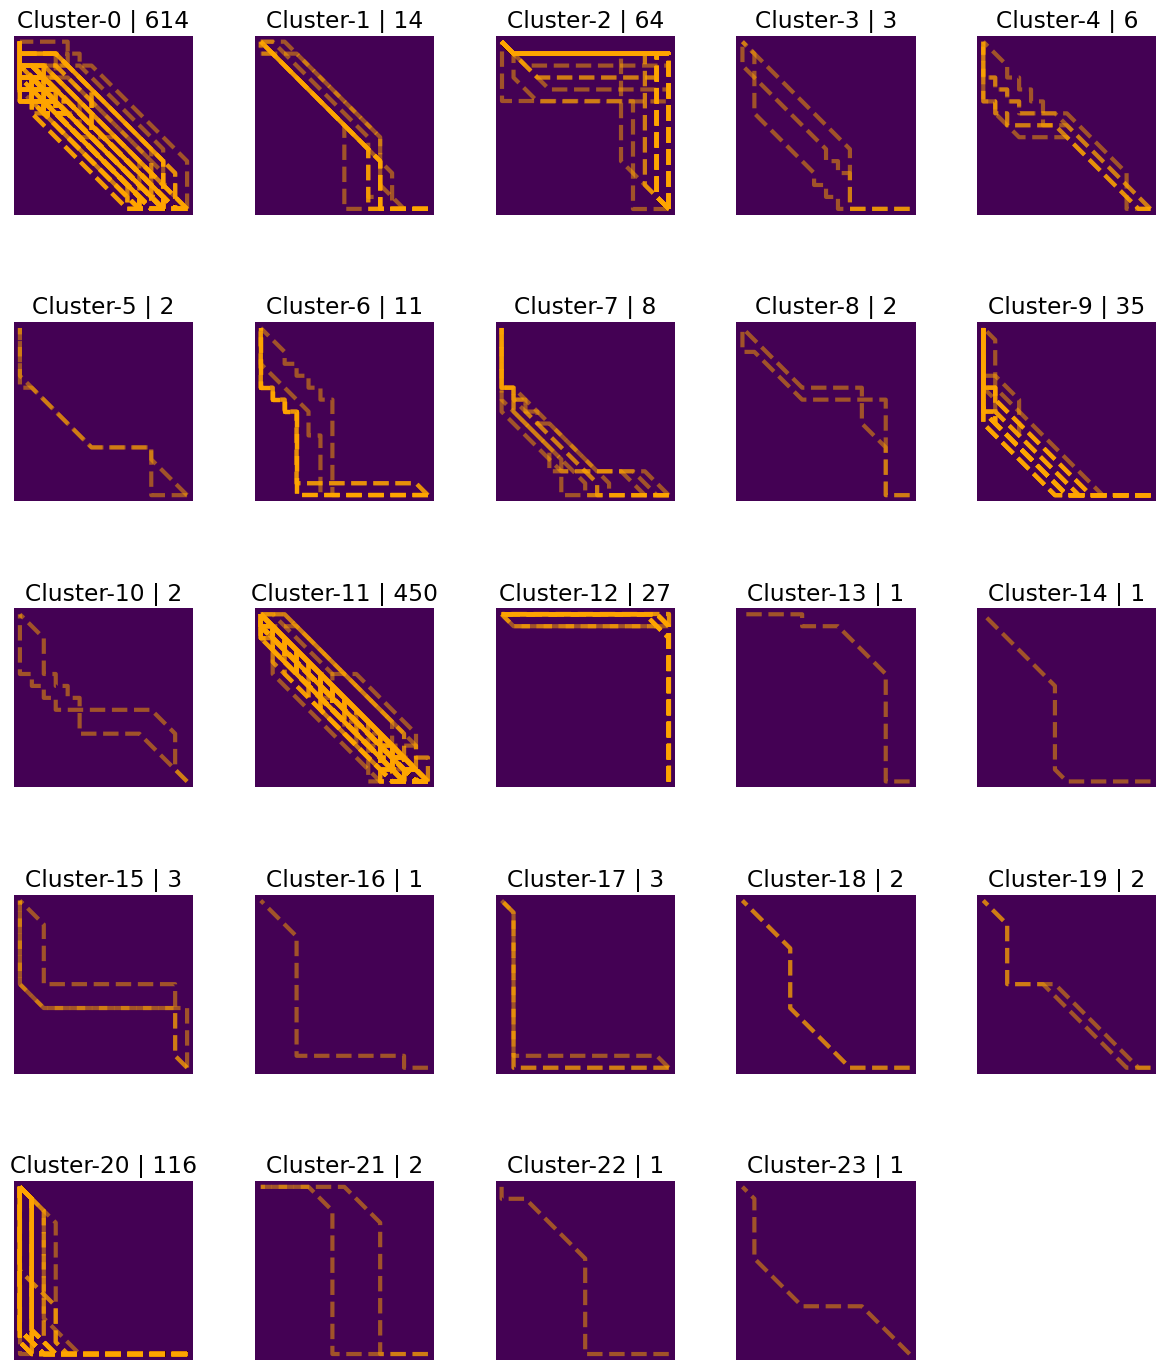

In [41]:
ClusterUtils.visualise_clusters(aligner)
#plt.savefig('plots/ExtendedFigsATOREF/clusters_high_res.png')

In [42]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIDMMMMMMMMMMMMD 614
cluster:  1 MMMMMMMMMVMVMMDD 14
cluster:  2 MWWWWWWWWWWWWWIIIIIIIIIIIII 64
cluster:  3 IIMMMMMMIIMMMIDDDDD 3
cluster:  4 IIIIIDIDIDDDDMMMMMMMD 6
cluster:  5 IIIIDDMMMMMMWWMMMM 2
cluster:  6 IIIIIDIDIDIIIIIIIDDDDDDDDDDD 11
cluster:  7 IIIIIDIDMMDMMMMDMMDD 8
cluster:  8 MDDMMMMMMMMMIIIIDD 2
cluster:  9 IIIIIDIDIMMMMMMMWWWWW 35
cluster:  10 IIIIIDIDIMDDDDDMMMMMM 2
cluster:  11 MMMMMMMMMMMIMMD 450
cluster:  12 IIIDDDDDDDDDDDDDMVVVVVVVVVV 27
cluster:  13 DDDDMMMDDMMMIIIIIIIIDD 1
cluster:  14 MMMMMMMIIMIIIMWWWWW 1
cluster:  15 IIIIIDIMMMWWWWWWWWWIIIIM 3
cluster:  16 IIDMMVVVVVVMMWMWWWWWMD 1
cluster:  17 MIVVVVVVVVVVVVDDDDDDDDDDDDD 3
cluster:  18 MMMMIIIIMMMMMMWDDD 2
cluster:  19 MVMVVVVDDDMMMWMMMMD 2
cluster:  20 IIIIIDIDIIIIMMMMWWWWWWWW 116
cluster:  21 DDDDDMMMMMVVVVVVVVVDDDD 2
cluster:  22 IIDMMMMMMVVVVVWMWWWWD 1
cluster:  23 IMVMVVMMMMWWWWMMMM 1


In [45]:
#for i in range(len(aligner.gene_clusters)):
#    for g in aligner.gene_clusters[i]:
#        aligner.results_map[g].cluster_id = i

MWWWWWWWWWWWWIIIIIIIIIIIIM
Optimal alignment cost: 36.46275874960353 nits
Alignment similarity percentage: 53.85 %


2

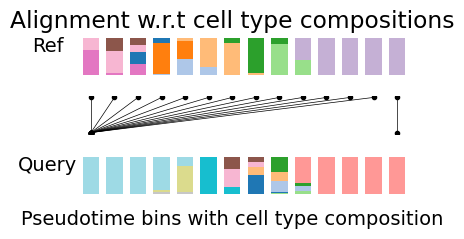

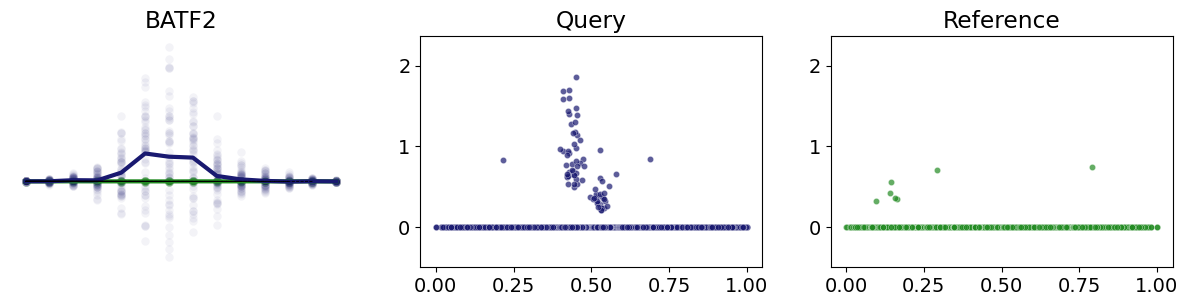

In [136]:
VisualUtils.show_gene_alignment('BATF2', aligner, vs, cmap=joint_cmap)
aligner.results_map['BATF2'].cluster_id

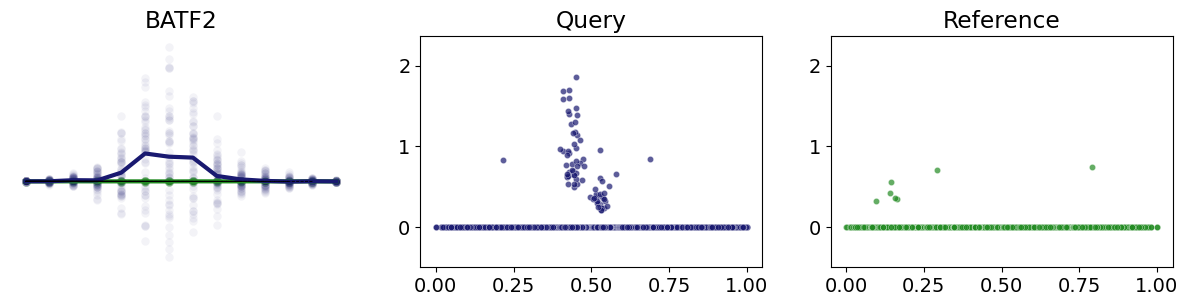

In [138]:
VisualUtils.plotTimeSeries('BATF2', aligner, plot_cells=True)
plt.savefig('plots/Supp/BATF2.png')

In [123]:
#VisualUtils.show_gene_alignment('HOXB8', aligner, vs, cmap=joint_cmap)
#aligner.results_map['HOXB8'].cluster_id

In [122]:
#for g in aligner.gene_clusters[2]:
#    VisualUtils.plotTimeSeries(g, aligner)

In [119]:
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[2])

Gene_set                                     Term Overlap  \
11  KEGG_2021_Human  Transcriptional misregulation in cancer   5/192   
12  KEGG_2021_Human     Maturity onset diabetes of the young    2/26   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
11  0.000373          0.009323            0                     0    8.949968   
12  0.003118          0.038972            0                     0   26.763441   

    Combined Score                     Genes  -log10 Adjusted P-value  \
11       70.652743  ETV7;FEV;SIX1;PPARG;PAX5                 2.030463   
12      154.441859              NKX6-1;FOXA2                 1.409242   

    -log10 FDR q-val  
11          2.030463  
12          1.409242

In [55]:
PathwayAnalyserV2.run_overrepresentation_analysis(aligner.gene_clusters[20])

Gene_set                                               Term  \
14       KEGG_2021_Human  Signaling pathways regulating pluripotency of ...   
0   MSigDB_Hallmark_2020                                Pancreas Beta Cells   
15       KEGG_2021_Human                            Hippo signaling pathway   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
14   7/143  0.000020          0.000723            0                     0   
0     3/40  0.001606          0.022489            0                     0   
15   5/163  0.002622          0.047188            0                     0   

    Odds Ratio  Combined Score                                 Genes  \
14    9.325148      100.860462  SOX2;DLX5;HAND1;SMAD9;OTX1;ISL1;TBX3   
0    14.240851       91.622619                       VDR;ISL1;NKX2-2   
15    5.623788       33.427744          SOX2;TEAD4;SNAI2;TEAD1;TEAD2   

    -log10 Adjusted P-value  -log10 FDR q-val  
14                 3.141011          3.141011  
0                  1.648031          1.648031  
15                 1.326170          1.326170

# Pathway geneset alignment

In [20]:
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase

class InterestingGeneSets:
    
    def __init__(self, MSIGDB_PATH ='../OrgAlign/msigdb/' ):        
        self.SETS = {}
        self.dbs = {}
        self.msigdb = MolecularSignaturesDatabase(MSIGDB_PATH , version='7.5.1')
        self.dbs['kegg'] = self.msigdb.load('c2.cp.kegg', 'symbols')
        self.dbs['hallmark'] = self.msigdb.load('h.all', 'symbols')
        #self.dbs['gobp'] = self.msigdb.load('c5.go.bp', 'symbols')
        #self.dbs['gocc'] = self.msigdb.load('c5.go.cc', 'symbols')
        self.dbs['reac'] = self.msigdb.load('c2.cp.reactome', 'symbols')
        
    def add_new_set_from_msigdb(self, db_name, dbsetname, avail_genes, usersetname):
        self.SETS[usersetname] = np.intersect1d(list(self.dbs[db_name].gene_sets_by_name[dbsetname].genes), avail_genes)

    def add_new_set(self, geneset, usersetname, avail_genes):
        geneset = np.asarray(geneset)
        #print(geneset)
        self.SETS[usersetname] = geneset[np.where([g in avail_genes for g in geneset])]
        
        
IGS = InterestingGeneSets(MSIGDB_PATH='../MSIGDB/msigdb7.5.1/')
IGS.add_new_set_from_msigdb('reac', 'REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPOTENT_STEM_CELLS', aligner.gene_list  , 'Reg_of_Pluripotency')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', common_genes, 'TNF_alpha_signaling_via_NFKB')
IGS.add_new_set(IGS.SETS['TNF_alpha_signaling_via_NFKB']  , 'TNF_alpha_signaling_via_NFKB_TFs', aligner.gene_list)   

In [21]:
print(len(IGS.SETS['TNF_alpha_signaling_via_NFKB_TFs'])) 
print(len(IGS.SETS['TNF_alpha_signaling_via_NFKB']))

42
196


mean matched percentage:  51.94 %
mean matched percentage wrt ref:  67.18 %
mean matched percentage wrt query:  65.99 %
Average Alignment:  IIIDIDIMMMMMMMMMDDD
Z-normalised Interpolated mean trends


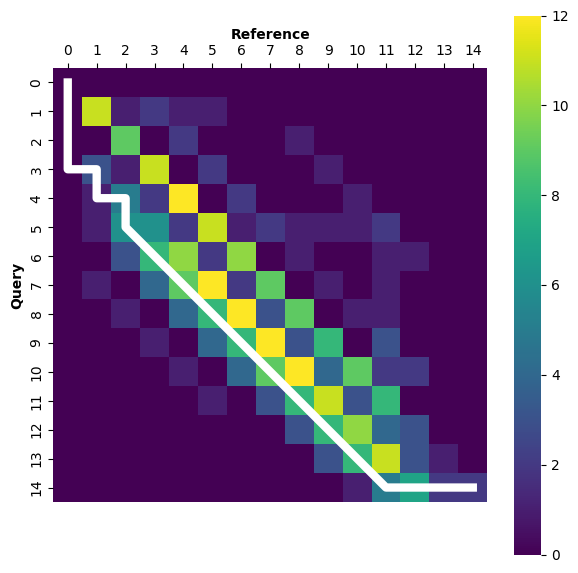

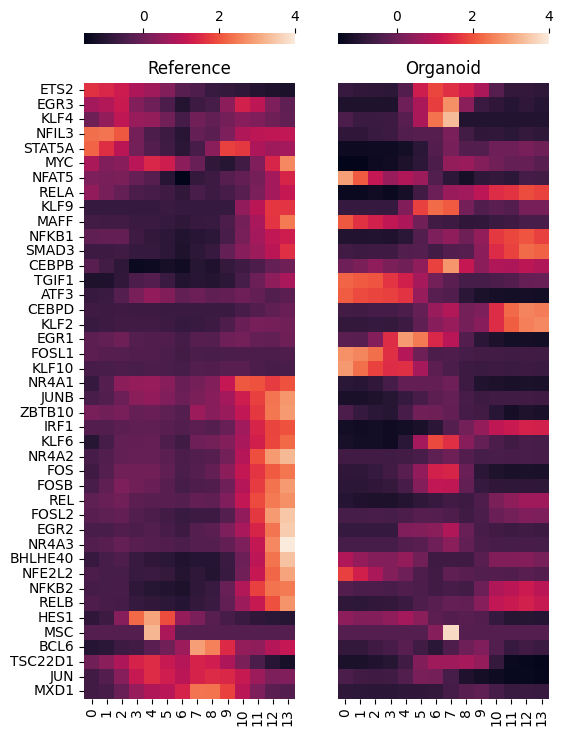

In [27]:
PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['TNF_alpha_signaling_via_NFKB_TFs'], 'TNF_alpha_signaling_via_NFKB_TFs', 
                                             cluster=True, FIGSIZE=(6,10))

Average Alignment:  IIIDIDIMMMMMMMMMDDD


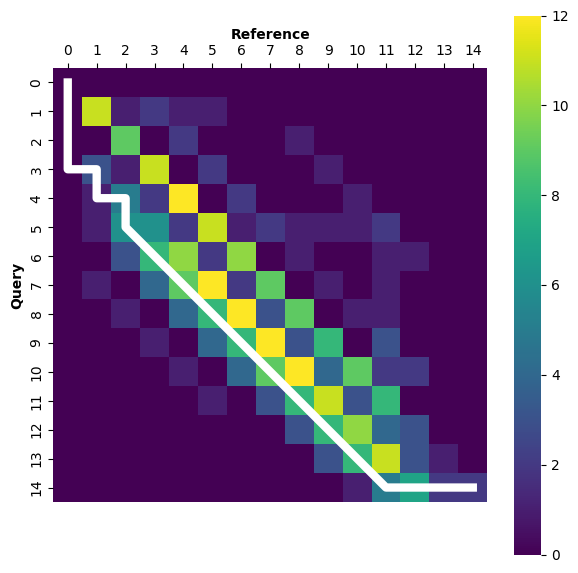

In [23]:
aligner.get_aggregate_alignment_for_subset(IGS.SETS['TNF_alpha_signaling_via_NFKB_TFs'])
plt.savefig('MS_FIGS/RefATO/average_tnfa_TFs_alignment.png')

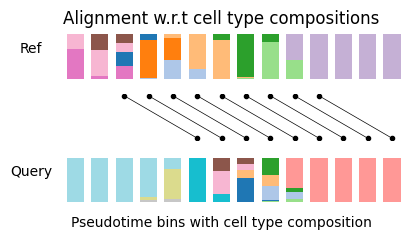

In [24]:
vs.visualize_gene_alignment('IIIDIDIMMMMMMMMMDDD', cmap=joint_cmap)
plt.savefig('MS_FIGS/RefATO/tnfa_average_alignment_illustration.pdf')

mean matched percentage:  51.21 %
mean matched percentage wrt ref:  67.14 %
mean matched percentage wrt query:  57.86 %
Average Alignment:  IIIDIDIDIDIDMDMMMMMMD
Z-normalised Interpolated mean trends


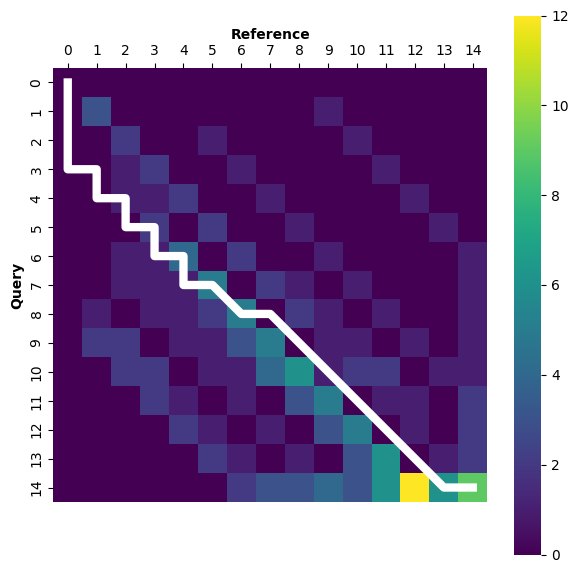

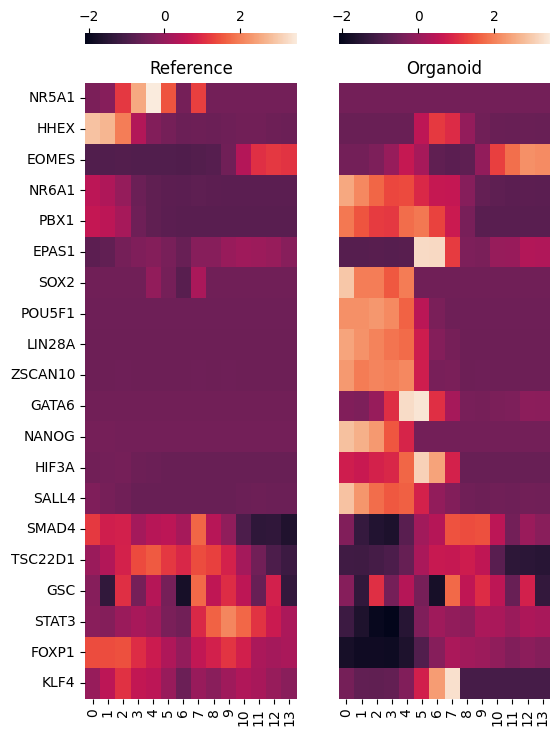

In [28]:
PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['Reg_of_Pluripotency'], 'Pluripotency', cluster=True, FIGSIZE=(6,10))

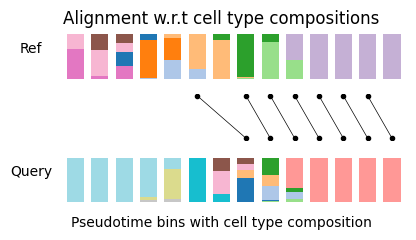

In [29]:
vs.visualize_gene_alignment('IIIDIDIDIDIDMDMMMMMMD', cmap=joint_cmap)
plt.savefig('MS_FIGS/RefATO/pluripotent_average_alignment_illustration.pdf')

Average Alignment:  IIIDIDIDIDIDMDMMMMMMD


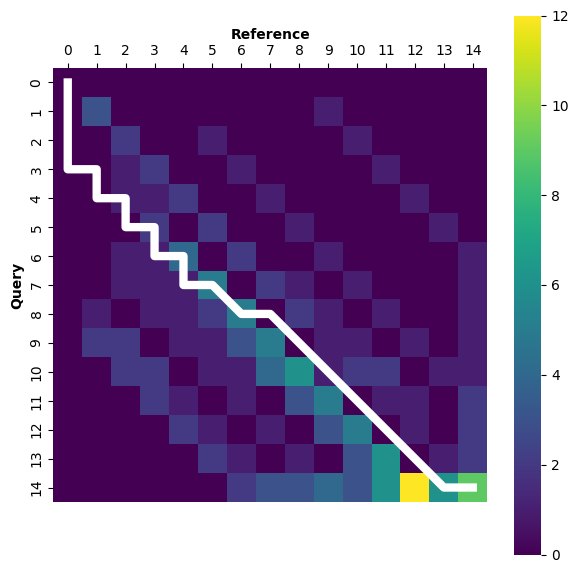

In [30]:
aligner.get_aggregate_alignment_for_subset(IGS.SETS['Reg_of_Pluripotency'])
plt.savefig('MS_FIGS/RefATO/average_pluripotency_TFs_alignment.png')

# Alignment of all genes in the TNFa pathway

In [185]:
gene_list = IGS.SETS['TNF_alpha_signaling_via_NFKB']
aligner_tnf = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
aligner_tnf.WEIGHT_BY_CELL_DENSITY = True
aligner_tnf.WINDOW_SIZE=0.1
aligner_tnf.state_params = [0.99,0.1,0.7]
aligner_tnf.optimal_binning = True
aligner_tnf.opt_binning_S = vs.optimal_bining_S
aligner_tnf.opt_binning_T = vs.optimal_bining_T
aligner_tnf.align_all_pairs()
#pickle.dump(aligner_tnf, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_tnf_genes.pkl', 'wb')) 

WINDOW_SIZE= 0.1


  0%|          | 0/196 [00:01<?, ?it/s]

In [11]:
with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_all_tnf_genes.pkl', 'rb') as f:
    aligner_tnf = pickle.load(f)

In [13]:
len(aligner.gene_list)
len(aligner_tnf.gene_list)

196

In [186]:
len(IGS.SETS['TNF_alpha_signaling_via_NFKB'])

196

Average Alignment:  IIIDIDIDIMMMMMMMMDDD


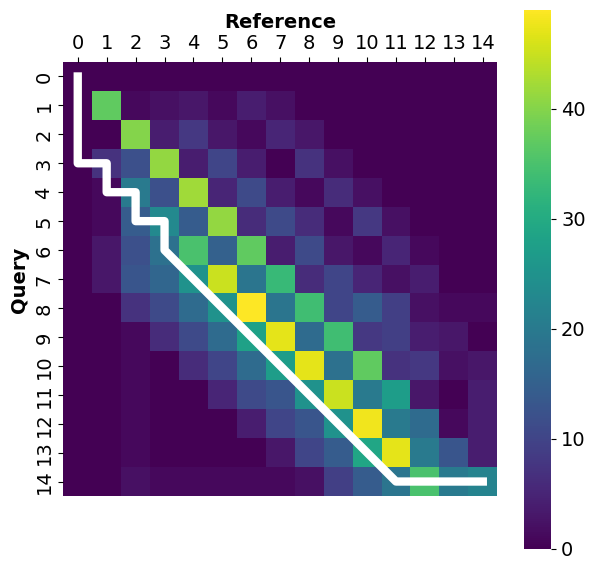

In [187]:
aligner_tnf.get_aggregate_alignment()
plt.savefig('MS_FIGS/RefATO/MoreFigs/TNFa_pathway_all_genes_average_alignment.png')

mean matched percentage: 
51.5 %


Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
42     DNAJB4                             0.0          72.073285  3.494666   
136      PLEK                            0.12          67.547629 -2.476898   
93        JUN                          0.1667          60.667438  1.954516   
143     PTGS2                          0.2143          66.609824 -0.280839   
20       CCL5                          0.2174          58.707419 -3.026268   
..        ...                             ...                ...       ...   
126      OLR1                          0.8667           6.456731 -4.136385   
67       GCH1                          0.8667          18.419765  0.094665   
111       MSC                           0.875           12.66121   0.57684   
155  SERPINB2                             1.0           -2.72529 -2.330031   
102     LAMB3                             1.0          -2.578321 -0.111973   

     color  abs_l2fc  
42     red  3.494666  
136    red  2.476898  
93     red  1.954516  
143    red  0.280839  
20     red  3.026268  
..     ...       ...  
126  green  4.136385  
67   green  0.094665  
111  green   0.57684  
155  green  2.330031  
102  green  0.111973  

[196 rows x 6 columns]

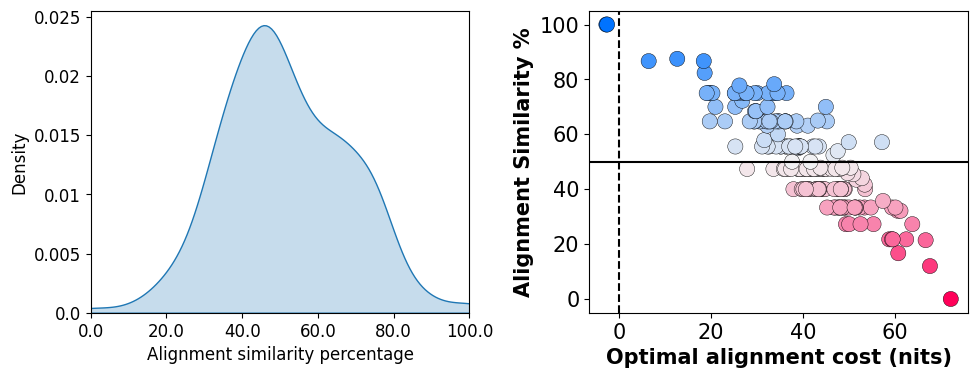

In [188]:
aligner_tnf.get_stat_df() 

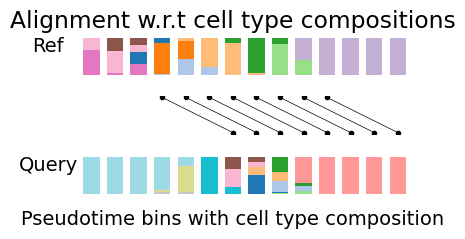

In [189]:
vs.visualize_gene_alignment('IIIDIDIDIMMMMMMMMDDD', cmap=joint_cmap)
plt.savefig('MS_FIGS/RefATO/MoreFigs/TNFa_pathway_all_genes_average_alignment_illustration.png')



In [191]:
print('a')

a


In [157]:
for g in ['BATF2','POU6F1','SOX18', 'CSRNP3'  ]:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(aligner.results_map[g].alignment_str) 
    plt.savefig('MS_FIGS/RefATO/'+g+'.png', bbox_inches='tight', transparent=True)
    plt.clf()
    

MMMMMMIIDDMMMMMM
IDMMMIIIMMMMMMMWWW
MMMMIIIIMMMMMMWWWW
MMMMMIIMMMMMMMWW


<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

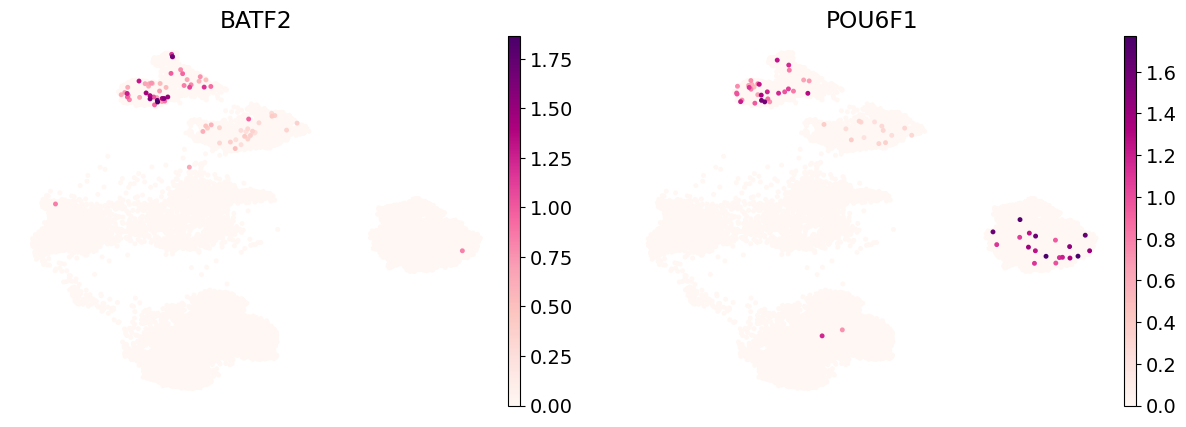

In [171]:
sc.pl.umap(adata_query, color = ['BATF2','POU6F1' ], frameon=False, cmap='RdPu',size=50, save='middle_mismatch_umap1.png')


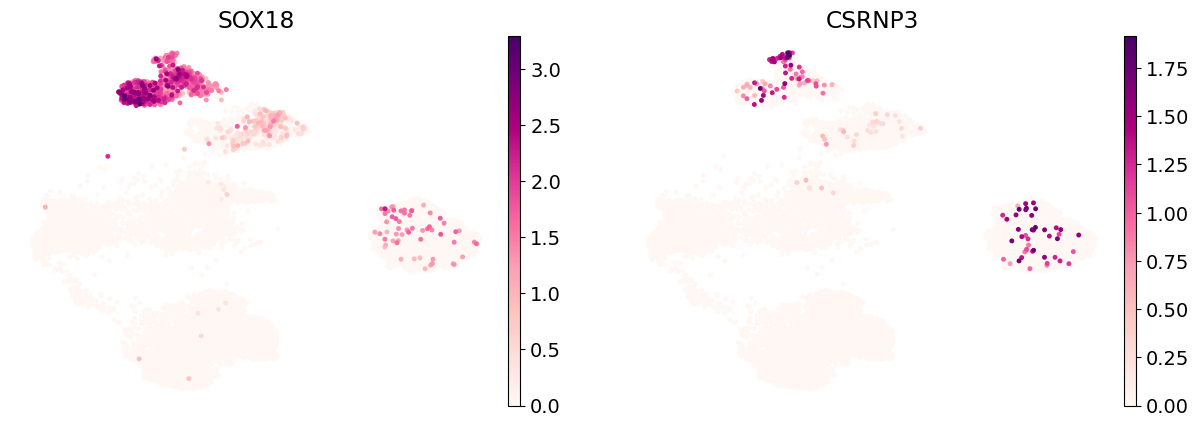

In [172]:
sc.pl.umap(adata_query, color = ['SOX18', 'CSRNP3' ], frameon=False, cmap='RdPu',size=50,save='middle_mismatch_umap2.png')

In [ ]:
for g in ['POU5F1','NANOG','SOX2','HHEX','FOSB','JUNB','NR4A2','KLF2']:
    VisualUtils.plotTimeSeries(g, aligner, plot_cells=True)
    print(aligner.results_map[g].alignment_str) 
    #plt.savefig('MS_FIGS/RefATO/'+g+'.png', bbox_inches='tight', transparent=True)
    #plt.clf()

In [41]:
#sc.pl.umap(adata_query, color = ['TBX3','BATF2','POU6F1', 'SOX18', 'CSRNP3' ,'LEF1','GATA6', 'SALL4', 'HOXB6', 'NACC2', 'PRDM6'], frameon=False, cmap='RdPu',size=50, save='_supp_umaps_ato.png', ncols=1)

In [42]:
#sc.pl.umap(adata_ref, color = ['TBX3','BATF2','POU6F1', 'SOX18', 'CSRNP3' ,'LEF1','GATA6', 'SALL4', 'HOXB6', 'NACC2', 'PRDM6'], frameon=False, cmap='RdPu',size=50, ncols=1,save='_supp_umaps_ref.png')

IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIIIIIDIMMIIDDDDDDDMMDD
IIIIIIIDIMMIIIIDDDDDDDDDDD
IIIIIIIDIMMIIIIDDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIIIIIIMMMMDMMWWWWWWW
MVVVVVMMMMWWWWDMMMM


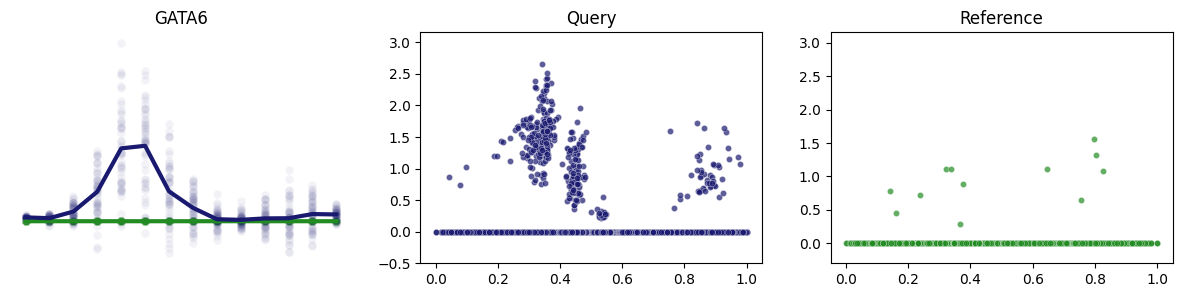

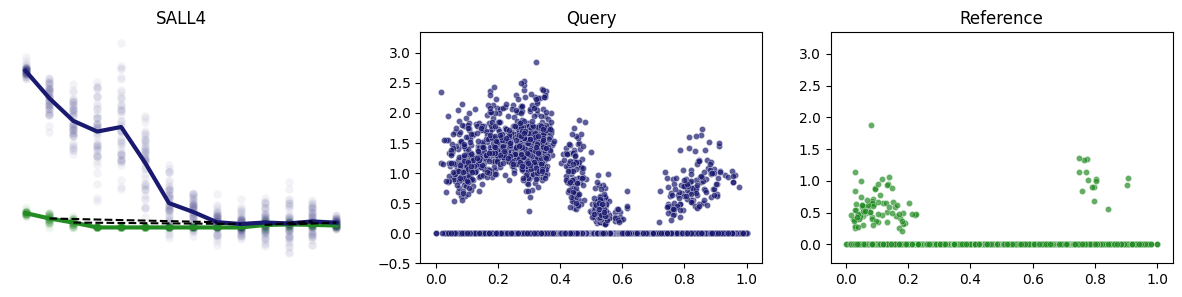

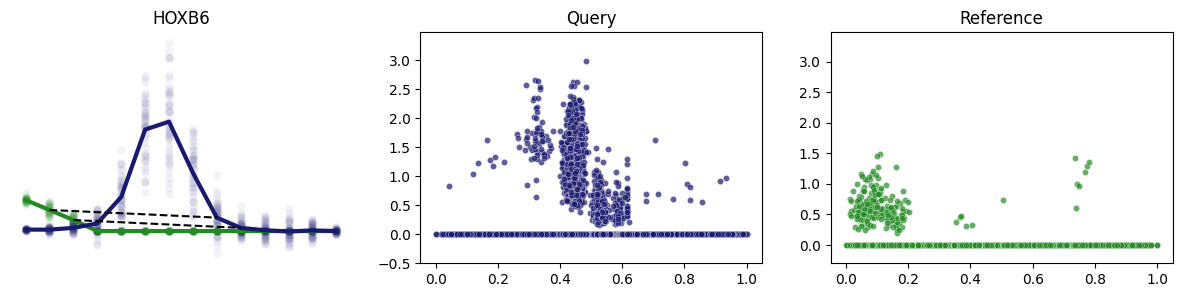

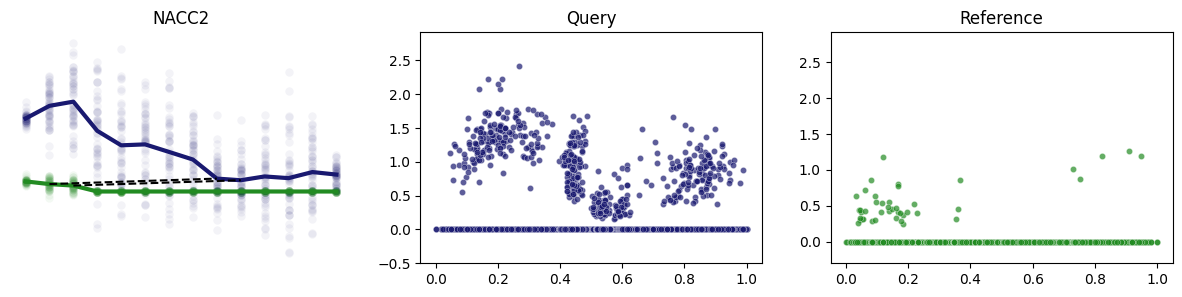

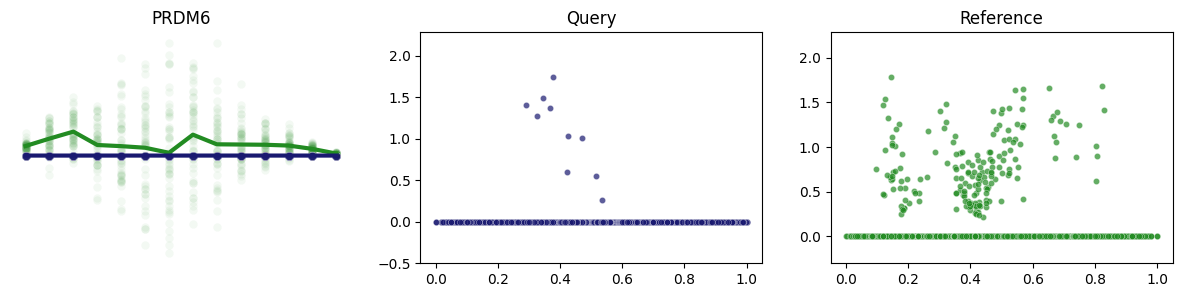

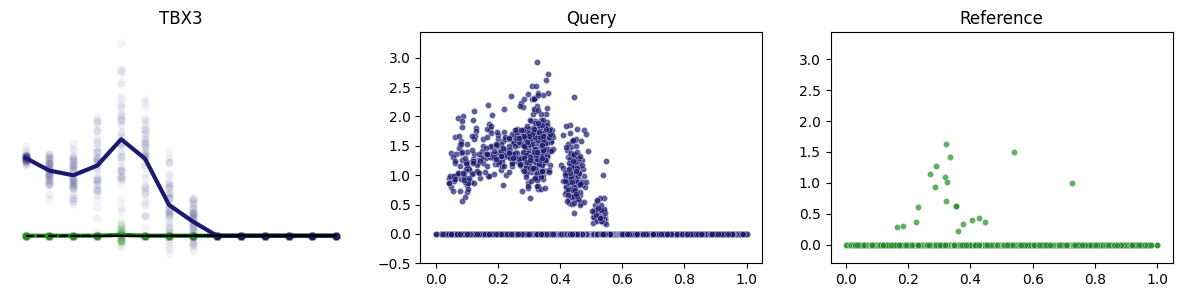

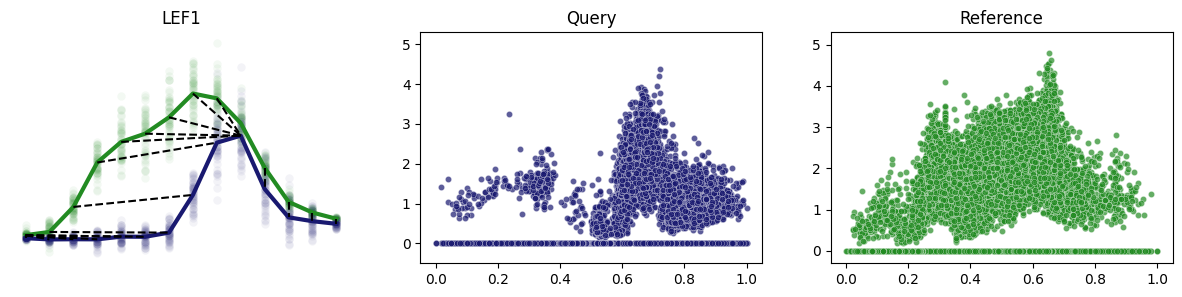

In [45]:
def plotTimeSeries(gene, aligner, plot_cells = False, plot_mean_trend= False):
    
        al_obj = aligner.results_map[gene]
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(gene, aligner) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(aligner.ref_mat[al_obj.gene])), np.max(np.asarray(aligner.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(aligner.ref_mat[al_obj.gene])), np.min(np.asarray(aligner.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=aligner.query_time, y=np.asarray(aligner.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=aligner.ref_time, y=np.asarray(aligner.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])
        
def plotTimeSeriesAlignment(gene, aligner):  
    
        al_obj = aligner.results_map[gene]
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)

for g in ['GATA6', 'SALL4', 'HOXB6', 'NACC2', 'PRDM6', 'TBX3', 'LEF1']:
    plotTimeSeries(g, aligner, plot_cells=True)
    print(aligner.results_map[g].alignment_str) 
    #plt.savefig('MS_FIGS/RefATO/MoreFigs/Supplementary/'+g+'.png', bbox_inches='tight', transparent=True)
    #plt.clf()

# Testing known gene markers of SP T maturity 

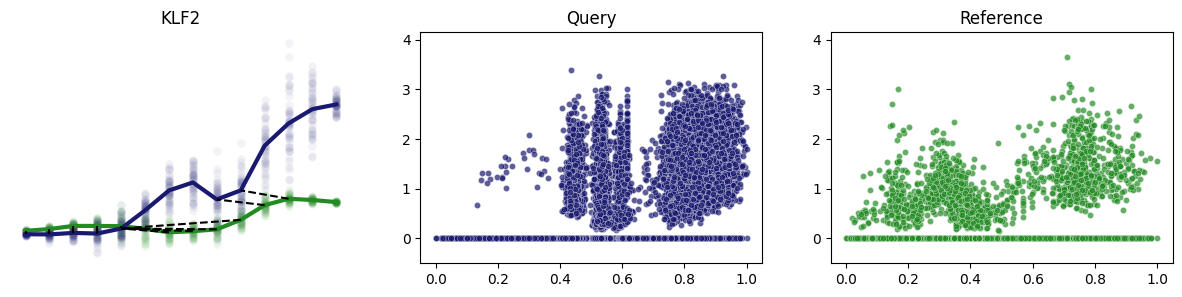

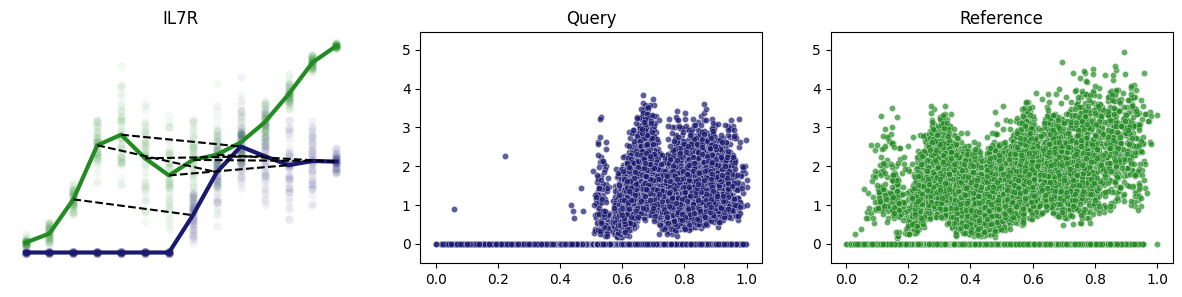

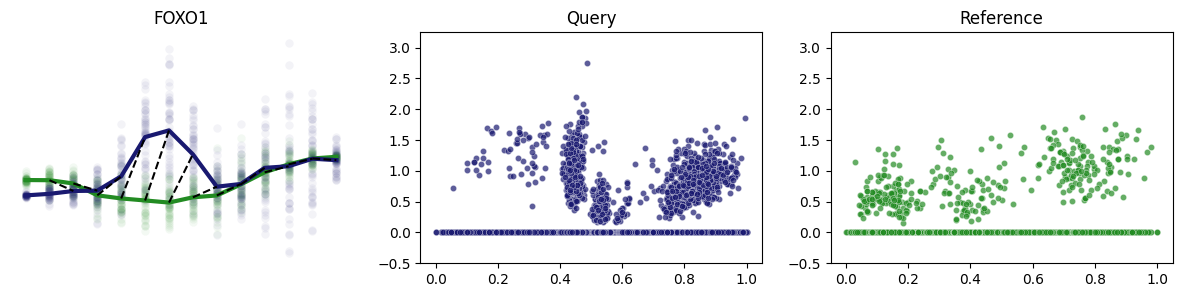

In [15]:
for g in [ 'KLF2','IL7R']:
    VisualUtils.plotTimeSeries(g, aligner_tnf, plot_cells = True)
VisualUtils.plotTimeSeries('FOXO1', aligner, plot_cells = True)

In [16]:
gene_list =['S1PR1', 'SELL']
aligner_temp = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
aligner_temp.WEIGHT_BY_CELL_DENSITY = True
aligner_temp.WINDOW_SIZE=0.1
aligner_temp.state_params = [0.99,0.1,0.7]
aligner_temp.optimal_binning = True
aligner_temp.opt_binning_S = vs.optimal_bining_S
aligner_temp.opt_binning_T = vs.optimal_bining_T
aligner_temp.align_all_pairs()

WINDOW_SIZE= 0.1


  0%|          | 0/2 [00:00<?, ?it/s]

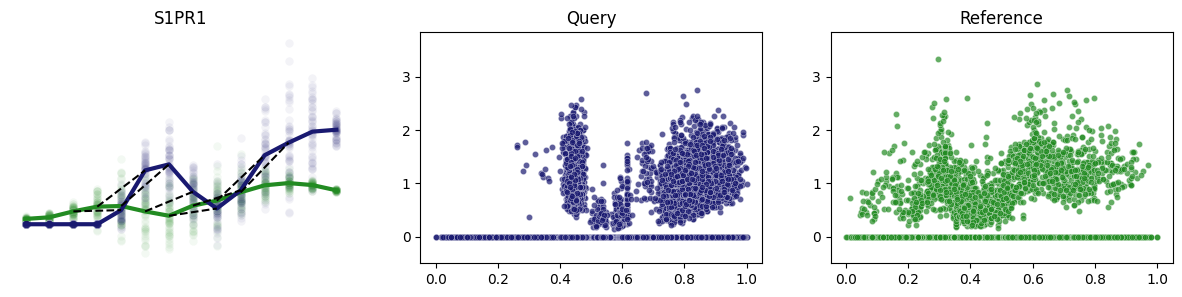

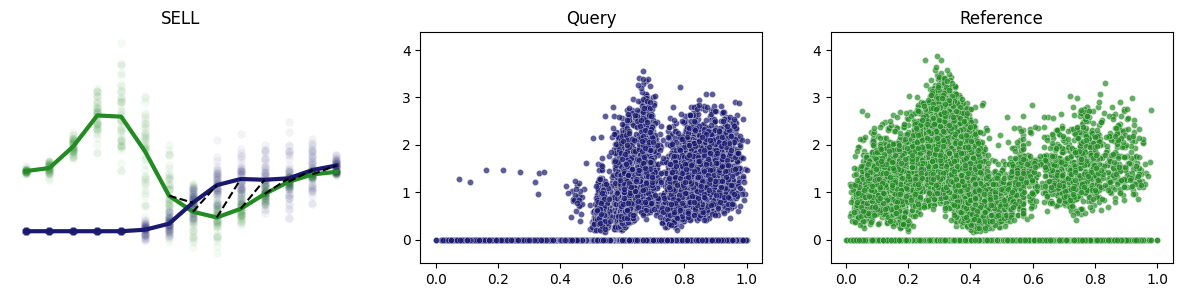

In [17]:
for g in ['S1PR1', 'SELL']:
    VisualUtils.plotTimeSeries(g, aligner_temp, plot_cells = True)

In [20]:
for g in ['S1PR1', 'SELL']:
    VisualUtils.plotTimeSeries(g, aligner_temp, plot_cells = True)
    print(aligner_temp.results_map[g].alignment_str) 
    plt.savefig('MS_FIGS/RefATO/TNFa_related/'+g+'.png', bbox_inches='tight', transparent=True)
    plt.clf()
for g in [ 'KLF2','IL7R']:
    VisualUtils.plotTimeSeries(g, aligner_tnf, plot_cells = True)
    plt.savefig('MS_FIGS/RefATO/TNFa_related/'+g+'.png', bbox_inches='tight', transparent=True)
    plt.clf()
VisualUtils.plotTimeSeries('FOXO1', aligner, plot_cells = True)
plt.savefig('MS_FIGS/RefATO/TNFa_related/FOXO1.png', bbox_inches='tight', transparent=True)
plt.clf()

IIIDIDMMMMMMMMIIDDDD
IIIDIDIDIDIDDMMMMMMMD


<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

# Writing alignments to file

In [39]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id']
df

Gene 5-state alignment string  Alignment similarity %  Cluster_id
0     AC023509.3     MMMMIIMMMMVVVVDDDDDD                   60.00          20
1     AC092835.1         MMMMMMMMMMIIMMDD                   75.00           4
2           ADNP       IIIDIMMMMMMMMMMDDD                   55.56           4
3          ADNP2          MMMMMMMMMMMIMMD                   86.67           4
4          AEBP1        IIDIDMMMMMMMMMMMD                   64.71           4
...          ...                      ...                     ...         ...
1366     ZSCAN5A         IIMMMMMMMMMMMMDD                   75.00           4
1367      ZSCAN9          MMMMMMMMMMMIMMD                   86.67           4
1368        ZXDA       MMMMMMMMMMVVVVDDDD                   77.78          20
1369        ZXDB          IMMMMMMMMMMMMMD                   86.67           4
1370        ZXDC      IIDMMMMMMMMMIIDIDDD                   47.37           4

[1371 rows x 4 columns]

In [43]:
np.mean(df['Alignment similarity %'])

65.67229759299781

In [42]:
len(np.unique(df.Cluster_id)) 
df.to_csv('results/G2G_RefATO_alignments.csv')

# Supplementary tests -- clustering alignments with Hamming distance vs. Levenshtein

compute distance matrix
using hamming distance metric


 68%|██████▊   | 67/99 [00:04<00:02, 14.10it/s]


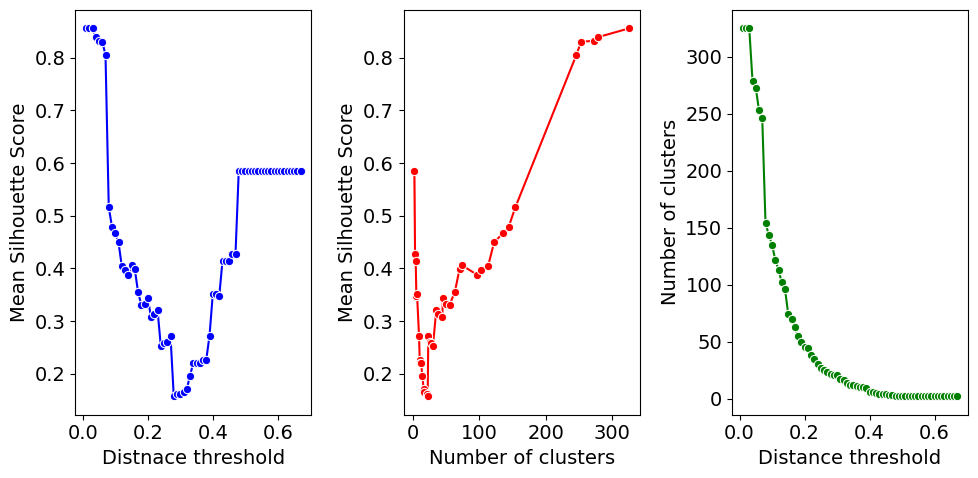

In [9]:
df = ClusterUtils.run_clustering(aligner, metric='hamming', experiment_mode=True)
plt.savefig('MS_FIGS/RefATO/Clustering_Diagnostic_plots_hamming.png')

In [8]:
temp = []
for a in aligner.results:
    temp.append(a.alignment_str)
len(np.unique(temp)) 

355

In [10]:
df

Distance threshold  Mean Silhouette Score  Number of clusters
0                 0.01               0.855580               325.0
1                 0.02               0.855580               325.0
2                 0.03               0.855580               325.0
3                 0.04               0.839119               279.0
4                 0.05               0.832063               273.0
..                 ...                    ...                 ...
62                0.63               0.585784                 2.0
63                0.64               0.585784                 2.0
64                0.65               0.585784                 2.0
65                0.66               0.585784                 2.0
66                0.67               0.585784                 2.0

[67 rows x 3 columns]

In [7]:
temp = []
for a in aligner.results:
    temp.append(a.alignment_str)
    
len(np.unique(temp)) 

212

In [85]:
d = ClusterUtils.run_clustering_for_subset(aligner,metric='levenshtein', MIN_DIST=0.00000001) 
# checking the number of unique alignment strings vs max number of clusters for randomly sampled alignment subsets 
print(np.mean(d['n_unique_strings'] - d['n_identified_clusters']))

using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levenshtein distance metric
using levensht

In [80]:
d = ClusterUtils.run_clustering_for_subset(aligner,metric='hamming', MIN_DIST=0.00000001) 
# checking the number of unique alignment strings vs max number of clusters for randomly sampled alignment subsets 
print(np.mean(d['n_unique_strings'] - d['n_identified_clusters']))

using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamming distance metric
using hamm

In [141]:
del adata_ref.layers['counts']
del adata_ref.obsp['connectivities']
del adata_ref.obsp['distances']
del adata_ref.obsm['X_gplvm']
del adata_ref.obsm['X_scVI']
del adata_ref.obsm['X_umap']
del adata_ref.uns
del adata_ref.var
adata_ref[:, human_TFs].write_h5ad('../TRADESEQ_TEST/g2g_datasets_to_test/adata_ref_spt.h5ad')

In [143]:
del adata_query.layers['counts']
del adata_query.obsp['connectivities']
del adata_query.obsp['distances']
del adata_query.obsm['X_gplvm']
del adata_query.obsm['X_scVI']
del adata_query.obsm['X_umap']
del adata_query.uns
del adata_query.var
adata_query[:, human_TFs].write_h5ad('../TRADESEQ_TEST/g2g_datasets_to_test/adata_ato_spt.h5ad')

In [165]:
df_r = pd.DataFrame(np.asarray(adata_ref.X.todense()) ) 
df_r.columns = adata_ref.var_names
df_r.index = adata_ref.obs_names
df_q = pd.DataFrame(np.asarray(adata_query.X.todense()) ) 
df_q.columns = adata_query.var_names
df_q.index = adata_query.obs_names

In [170]:
#df_r.to_csv('../TRADESEQ_TEST/g2g_datasets_to_test/adata_ref_spt.csv', header=True)

In [ ]:
visualize_gene_alignment(aligner.results_map['HHEX'])

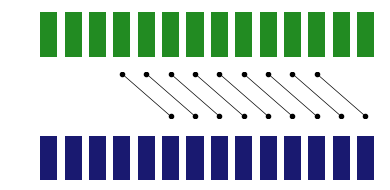

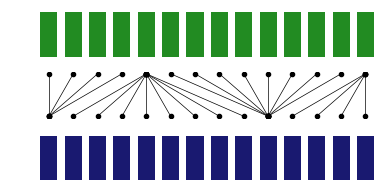

In [8]:
temp_qcmap = {}
for k in joint_cmap.keys():
    temp_qcmap[k] = 'midnightblue'
temp_rcmap = {}
for k in joint_cmap.keys():
    temp_rcmap[k] = 'forestgreen'

def visualize_gene_alignment(alignment, cmap=None):

            ref_cmap = temp_rcmap
            query_cmap= temp_qcmap
            if(isinstance(alignment,Main.AligmentObj )):
                alignment = alignment.alignment_str

            matched_points_S, matched_points_T = vs.get_matched_time_points(alignment)

            fig = plt.figure(figsize=(4,2))
            heights = [1, 1, 1] 
            gs = plt.GridSpec(3, 1, height_ratios=heights)
            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
            ax3 = fig.add_subplot(gs[2, 0],sharex=ax1)

            plt.subplot(3,1,1)
            vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ref_cmap, grid = False, legend=False, width=0.7, ax=ax1)
            vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=query_cmap, grid = False, legend=False, width=0.7,ax=ax3)
            plt.subplot(3,1,2)
            for i in range(len(matched_points_S)):
                        S_timebin = matched_points_S[i]
                        T_timebin = matched_points_T[i]
                        x_vals = [T_timebin+1, S_timebin+1]
                        y_vals = [0,1]
                        plt.plot(x_vals, y_vals, marker='.', color='black', linewidth=0.5)

            def set_grid_off(ax):
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_xticks([])
                ax.xaxis.set_ticks_position('none') 
                ax.set_yticks([])
                ax.figure.tight_layout()
                ax.grid(False)

            set_grid_off(ax1); set_grid_off(ax2); set_grid_off(ax3); 
          #  ax1.set_ylabel('Ref', rotation=0)
          #  ax3.set_ylabel('Query',rotation=0)
           # fig.text(0.5, -0.05, 'Pseudotime bins with cell type composition', ha='center')
           # ax1.set_title('Alignment w.r.t cell type compositions')

# CellAlign gives: ' M W W W M V V V V V V V M W W W W W W W M V V V'

visualize_gene_alignment(aligner.results_map['HHEX'])
#plt.savefig('plots/Fig3/HHEX_g2g_illustration.png')
visualize_gene_alignment('"MWWWMVVVVVVVMWWWWWWWMVVV"', cmap=joint_cmap)
#plt.savefig('plots/Fig3/HHEX_cellalign_illustration.png')

#VisualUtils.plotTimeSeries('HHEX', aligner, plot_cells=True)

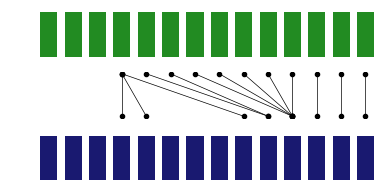

In [9]:
visualize_gene_alignment('DDDIDIIVVIIIVMWMWWWWMMM', cmap=joint_cmap)

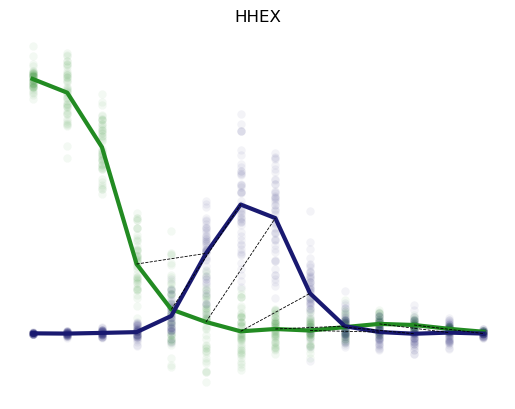

In [10]:
VisualUtils.plotTimeSeriesAlignment('HHEX',aligner)

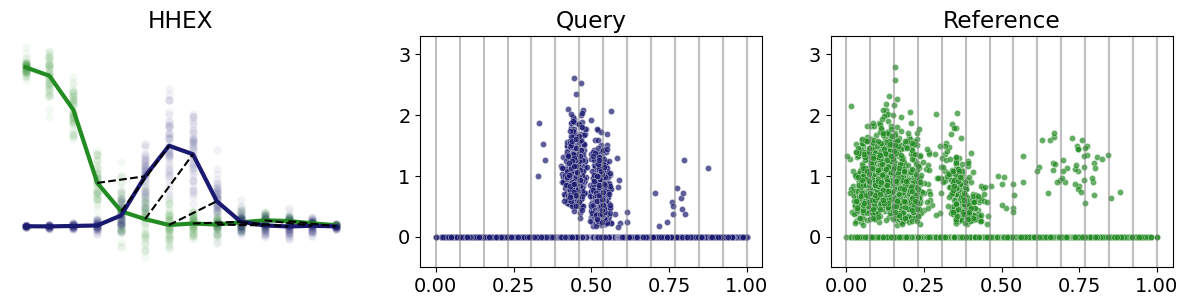

In [213]:
def plotTimeSeries(gene, aligner, plot_cells = False, plot_mean_trend= False):
    
        al_obj = aligner.results_map[gene]
        plt.subplots(1,3,figsize=(15,3))
        plt.subplot(1,3,1)
        plotTimeSeriesAlignment(al_obj) 
        plt.subplot(1,3,2)
        max_val = np.max([np.max(np.asarray(aligner.ref_mat[al_obj.gene])), np.max(np.asarray(aligner.query_mat[al_obj.gene]))])
        min_val = np.min([np.min(np.asarray(aligner.ref_mat[al_obj.gene])), np.min(np.asarray(aligner.query_mat[al_obj.gene]))])
        g = sb.scatterplot(x=aligner.query_time, y=np.asarray(aligner.query_mat[al_obj.gene]), alpha=0.7, color = 'midnightblue', legend=False,linewidth=0.3, s=20)  
        plt.title('Query')
        plt.ylim([min_val-0.5,max_val+0.5])
        for b in vs.optimal_bining_S:
            plt.axvline(b, color='grey', alpha=0.5)
        plt.subplot(1,3,3)
        g = sb.scatterplot(x=aligner.ref_time, y=np.asarray(aligner.ref_mat[al_obj.gene]), color = 'forestgreen', alpha=0.7, legend=False,linewidth=0.3,s=20 ) 
        plt.title('Reference')
        plt.ylim([min_val-0.5,max_val+0.5])
        for b in vs.optimal_bining_S:
            plt.axvline(b, color='grey', alpha=0.5)
        

def plotTimeSeriesAlignment(al_obj):  
    
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)
            


plotTimeSeries('HHEX',aligner)
plt.savefig('plots/Fig3/HHEX_g2g.png')

In [203]:
vs.optimal_bining_T

array([0.        , 0.07692308, 0.15384615, 0.23076923, 0.30769231,
       0.38461538, 0.46153846, 0.53846154, 0.61538462, 0.69230769,
       0.76923077, 0.84615385, 0.92307692, 1.        ])

In [201]:
print(VisualUtils.color_al_str("MWWWMVVVVVVVMWWWWWWWMVVV")) 

print(VisualUtils.color_al_str(aligner.results_map['HHEX'].alignment_str))

MWWWMVVVVVVVMWWWWWWWMVVV
IIIDIDIDMMMMMMMMMDD


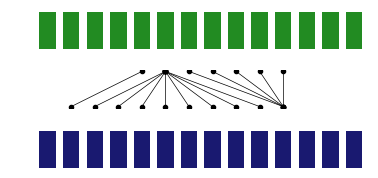

In [197]:
visualize_gene_alignment("MWWWMVVVVVVVMWWWWWWWMVVV", cmap=joint_cmap)

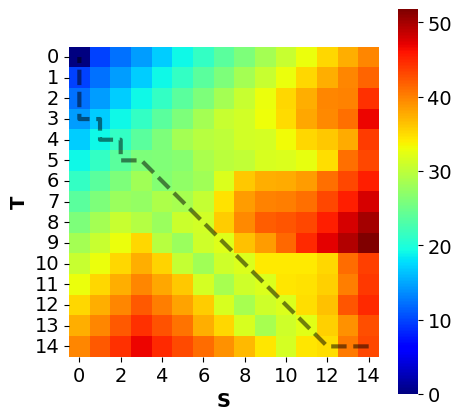

In [193]:
aligner.results_map['HHEX'].landscape_obj.

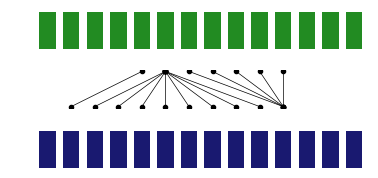

In [196]:
def plotTimeSeriesAlignment(al_obj):  
    
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.plot_mean_trends() 
        plt.title(al_obj.gene)
        plt.xlabel('pseudotime')
        plt.ylabel('Gene expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)
            
        for b in vs.optimal_bining_S:
            plt.axvline(b)
    
def visualize_gene_alignment(alignment, cmap=None):

            ref_cmap = temp_rcmap
            query_cmap= temp_qcmap
            if(isinstance(alignment,Main.AligmentObj )):
                alignment = alignment.alignment_str

            matched_points_S, matched_points_T = vs.get_matched_time_points(alignment)

            fig = plt.figure(figsize=(4,2))
            heights = [1, 1, 1] 
            gs = plt.GridSpec(3, 1, height_ratios=heights)
            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[1, 0],sharex=ax1)
            ax3 = fig.add_subplot(gs[2, 0],sharex=ax1)
            


            plt.subplot(3,1,1)
            vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=ref_cmap, grid = False, legend=False, width=0.7, ax=ax1)
            vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=query_cmap, grid = False, legend=False, width=0.7,ax=ax3)
            plt.subplot(3,1,2)
            
            matched_points_S = rarr
            matched_points_T =qarr
            for i in range(14):
                        S_timebin = matched_points_S[i]
                        T_timebin = matched_points_T[i]
                        x_vals = [T_timebin+1, S_timebin+1]
                        y_vals = [0,1]
                        plt.plot(x_vals, y_vals, marker='.', color='black', linewidth=0.5)

            def set_grid_off(ax):
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_xticks([])
                ax.xaxis.set_ticks_position('none') 
                ax.set_yticks([])
                ax.figure.tight_layout()
                ax.grid(False)

            set_grid_off(ax1); set_grid_off(ax2); set_grid_off(ax3); 
    

#plotTimeSeriesAlignment(aligner.results_map['HHEX'])


rarr = [4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 14, 14, 14]
qarr =[1 , 2,  3,  4,  5,  6,  7,  8,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 13, 14]

visualize_gene_alignment('HHEX')


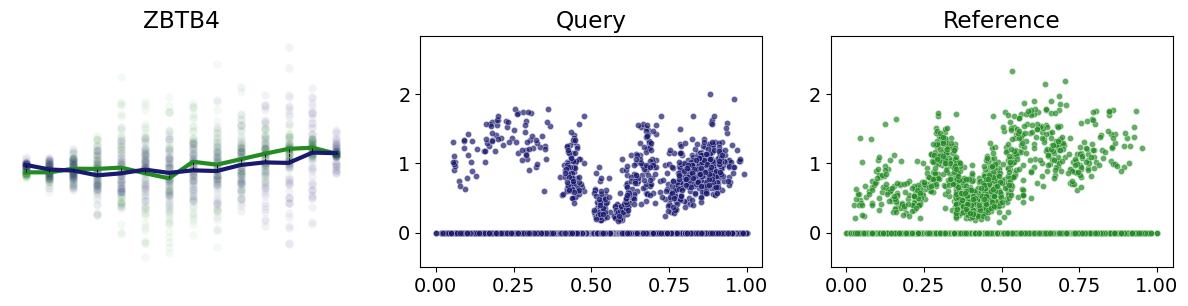

In [14]:
VisualUtils.plotTimeSeries('ZBTB4', aligner)

In [1]:
#aligner.show_ordered_alignments()